# RBP regulome of axonal localization 
June, 2023

## Table of contents
1. [Load the data](#1-load-the-data)
2. [Define the classification labels](#2-define-the-classification-labels)
3. [Choose a model](#3-choose-a-model)
    1. [Logistic regression](#31-logistic-regression)
    2. [Multilayer Perceptron Classifier (MLP)](#32-multilayer-perceptron-classifier-mlp)
    3. [XGBoost](#33-xgboost)
    4. [Model comparison](#34-model-comparison)
4. [Model 1: All 44 RBPs (M1)](#4-model-1-all-44-rbps-m1)
5. [Model 2: The 33 RBPs positive regulators of localization (M2)](#5-model-2-the-33-rbps-positive-regulators-of-localization-m2)
6. [Model 3: The 11 RBPs negative regulators of localization (M3)](#6-model-3-the-11-rbps-negative-regulators-of-localization-m3)
7. [Model 4: The top 42 nteractions between RBPs (M4)](#7-model-4-the-top-42-interactions-between-rbps-m4)
8. [Model comparison (M1, M2, M3 & M4)](#8-model-comparison-m1-m2-m3--m4)

In [1]:
## Imports 
import os
import sys
import pickle
import logging
import numpy as np
import pandas as pd
from gtfparse import read_gtf
from itertools import combinations

## Stats
import statsmodels.formula.api as smf

## plotting
import matplotlib.pyplot as plt
import seaborn as sns

## warnings
import warnings
warnings.filterwarnings('ignore')

## sklearn
import sklearn
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

## Scripts
sys.path.insert(1, "/".join(os.getcwd().split('/')[:-1]))
from scripts.ml_utils import *
from scripts.logistic_regression_utils import *

## Shapley values
import shap
from shap import KernelExplainer
logging.getLogger("shap").setLevel(logging.WARNING)

In [2]:
## plotting style
sns.set(font_scale=1.2, style='ticks')

CustomPalette = sns.color_palette(['#81A4D6', '#AE72B0'])
palette = {'transport_ngf': CustomPalette[0],
           'transport_nt3': CustomPalette[1]}

palette_conditions = {'NGF': CustomPalette[0],
           'NT3': CustomPalette[1]}

CustomNGFShades = sns.color_palette(['#A5C7FB', '#81A4D6', '#5D81B1', '#39608E', '#0F416B', '#00244B', '#729AD2', '#4F7AAF'])
CustomNT3Shades = sns.color_palette(['#FFE4FF', '#AE72B0', '#8F5692', '#723A75', '#551F59', '#3A023F', '#3D0043'])


continuous_palette = [CustomNGFShades, CustomNT3Shades]

## 1. Load the data

In [3]:
path_to_results = "./Results/"

df_cl = pd.read_csv("./data/cross_link_events.csv", index_col=0)
negative_regulators = pd.read_csv("./data/negative_regulators_axonal_localisation.csv")
negative_regulators = [neg.split('_')[0].upper() 
                       for neg in negative_regulators.Clips.values if type(neg) == str]

negative_regulators.remove('IGF2BP2') # Remove IGFBP2 from the list because in considered as a positive one in K652 cell line

## 2. Define the classification labels

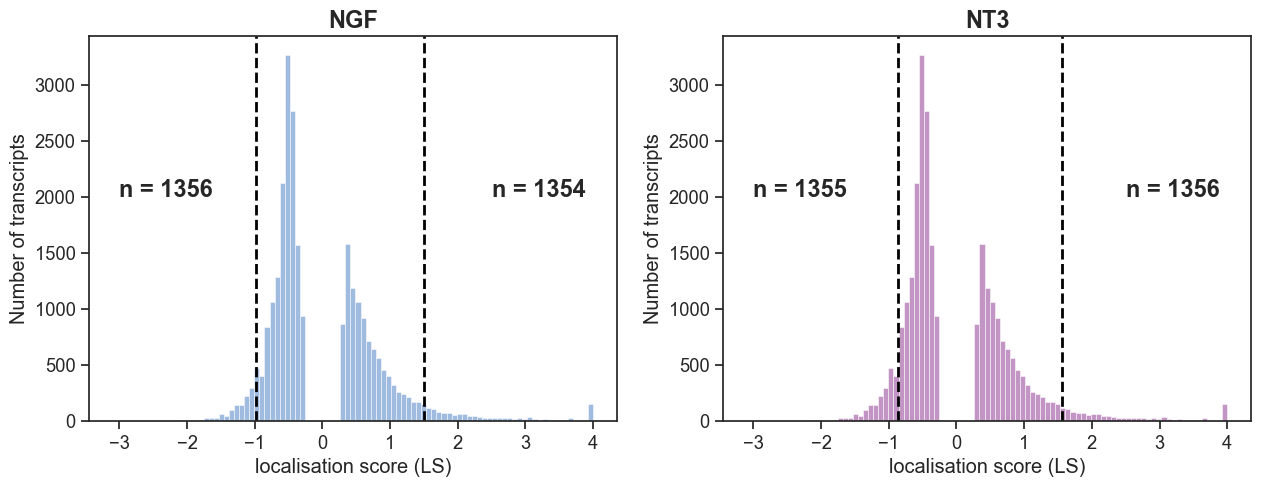

In [4]:
# Define some parameters
conditions_names = ['NGF', 'NT3'] # short-names for the conditions
test_size = 0.2 # size of the testing set
nb_shapley=50 # number of samples on which to compute the shapley values

pct_data_to_keep = 0.1 # fraction of the data to keep (the extremes will be kept)

parameters_lr={'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'], 
               'penalty': ['l2', 'l1', 'elasticnet'],
               'C': [0.01]} # grid-search parameters for logistic regression


datasets_per_condition = {}
plt.figure(figsize=(15, 5))

for i, condition in enumerate(['transport_ngf', 'transport_nt3']):
    threshold_up = df_cl.sort_values(condition, ascending=False).reset_index().loc[int(np.floor(len(df_cl)*(pct_data_to_keep/2)))][condition]
    threshold_down = df_cl.sort_values(condition).reset_index().loc[int(np.floor(len(df_cl)*(pct_data_to_keep/2)))][condition]
    
    label_name = 'IS_OVERTRANSPORTED_'+conditions_names[i]
    df_condition = set_binary_labels(df_data=df_cl,
                                     col_scores=condition,
                                     threshold_down=threshold_down,
                                     threshold_up=threshold_up,
                                     label_name=label_name).drop(['transport_ngf',
                                                                  'transport_nt3'], axis=1)
    X = df_condition.drop(label_name, axis=1)
    y = df_condition[label_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    

    datasets_per_condition[condition] = {}
    datasets_per_condition[condition]['dataset'] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
    
    positive_cols = [col for col in X_train.columns if col not in negative_regulators]
    negative_cols = [col for col in X_train.columns if col in negative_regulators]
    
    datasets_per_condition[condition]['dataset_positive'] = {'X_train': X_train[positive_cols], 
                                                             'X_test': X_test[positive_cols],
                                                             'y_train': y_train, 
                                                             'y_test': y_test}
    
    datasets_per_condition[condition]['dataset_negative'] = {'X_train': X_train[negative_cols], 
                                                             'X_test': X_test[negative_cols],
                                                             'y_train': y_train, 
                                                             'y_test': y_test}
    
    plt.subplot(1, 2, i+1)
    sns.histplot(df_cl, x='transport_ngf', color=palette[condition])
    plt.title(condition.split('_')[1].upper(), weight='bold', fontsize=17)
    plt.axvline(x=threshold_down, linestyle='dashed', linewidth=2, color='black')
    plt.axvline(x=threshold_up, linestyle='dashed', linewidth=2, color='black')
    plt.xlabel("localisation score (LS)")
    plt.ylabel("Number of transcripts")
    plt.text(s="n = "+str(len(df_cl[df_cl[condition] < threshold_down])), y=2000, x=-3, fontsize=17, weight='bold')
    plt.text(s="n = "+str(len(df_cl[df_cl[condition] > threshold_up])), y=2000, x=2.5, fontsize=17, weight='bold')                                   

## 3. Choose a model

### 3.1 Logistic regression

In [5]:
train_logistic_all_conditions(datasets_per_condition=datasets_per_condition,
                              dataset_key='dataset',
                              include_plots=False,
                              print_report=False,
                              conditions_names=conditions_names, 
                              palette=palette,
                              step_learning=10, 
                              feature_name_col='RBP',
                              negative_regulators=negative_regulators,                               
                              parameters_lr={'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'], 
                                        'penalty': ['l2', 'l1', 'elasticnet'], 
                                        'C': [0.01]})

Fitting 20 folds for each of 15 candidates, totalling 300 fits
Fitting 20 folds for each of 15 candidates, totalling 300 fits


### 3.2 Multilayer Perceptron Classifier (MLP)

In [6]:
for condition, lr in zip(datasets_per_condition.keys(), ['adaptive', 'constant']):

      X_train, X_test, y_train, y_test = datasets_per_condition[condition]['dataset'].values()

      model = MLPClassifier(solver='sgd', learning_rate_init=0.005, hidden_layer_sizes=(40,), 
                            activation='logistic', learning_rate=lr)
      
      model.fit(X_train, y_train)
      datasets_per_condition[condition]['MLP_model'] = model

### 3.3 XGBoost

In [7]:
for color, condition in zip(['cornflowerblue', 'mediumpurple'], datasets_per_condition.keys()):
    X_train, X_test, y_train, y_test = datasets_per_condition[condition]['dataset'].values()
    if type(y_train) == pd.DataFrame:
        scale_pos_weight = ((len(y_train) - y_train.sum())/y_train.sum()).values[0]
    else:
        scale_pos_weight = ((len(y_train) - y_train.sum())/y_train.sum())
        
    datasets_per_condition[condition]['XGBoost_model'] = xgb.XGBClassifier(tree_method='approx', enable_categorical=True, 
                                                                           scale_pos_weight=scale_pos_weight, alpha=0.1, n_estimators=500,
                                                                           colsample_bytree=0.5, subsample=0.5, learning_rate=0.001)
    datasets_per_condition[condition]['XGBoost_model'].fit(X_train, y_train, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0);

### 3.4 Model comparison

Text(0.5, 0.98, 'Classification scores for the different models')

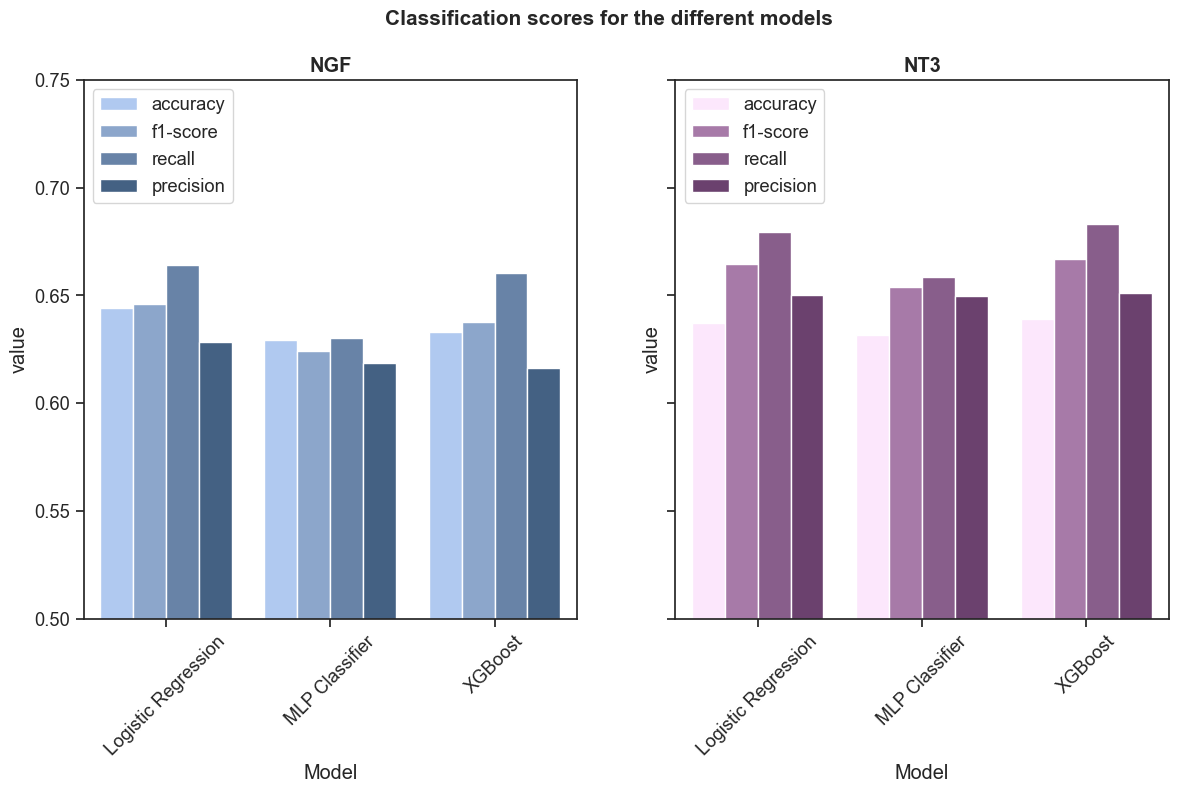

In [8]:
## Plot summarizing the metrics
dfs_summary = {}
for condition in datasets_per_condition.keys():
    
    dfs_summary[condition] = {}
    
    X_train, X_test, y_train, y_test = datasets_per_condition[condition]['dataset'].values()

    # Logistic regression 
    y_pred = datasets_per_condition[condition]['logit_model'].predict(X_test)
    
    report = sklearn.metrics.classification_report(y_test, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1_score = report['1']['f1-score']
    recall = report['1']['recall']
    precision = report['1']['precision']
    dfs_summary[condition]['Logistic Regression'] = {'accuracy': accuracy, 
                                                                       'f1-score': f1_score, 
                                                                       'recall': recall, 
                                                                       'precision': precision}
    
    # MLP
    y_pred = datasets_per_condition[condition]['MLP_model'].predict(X_test)
    
    report = sklearn.metrics.classification_report(y_test, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1_score = report['1']['f1-score']
    recall = report['1']['recall']
    precision = report['1']['precision']
    dfs_summary[condition]['MLP Classifier'] = {'accuracy': accuracy, 
                                                                       'f1-score': f1_score, 
                                                                       'recall': recall, 
                                                                       'precision': precision}
    
    # XGBoost
    y_pred = datasets_per_condition[condition]['XGBoost_model'].predict(X_test)
    
    report = sklearn.metrics.classification_report(y_test, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1_score = report['1']['f1-score']
    recall = report['1']['recall']
    precision = report['1']['precision']
    dfs_summary[condition]['XGBoost'] = {'accuracy': accuracy, 
                                                                       'f1-score': f1_score, 
                                                                       'recall': recall, 
                                                                       'precision': precision}

fig, ax = plt.subplots(1, len(dfs_summary.keys()), figsize=(7*len(dfs_summary.keys()), 7), sharey=True)

for i, condition in enumerate(dfs_summary.keys()):
    df = pd.DataFrame(dfs_summary[condition])
    scores = list(df.index)
    df_plot = pd.melt(df, var_name='Model')
    df_plot['Score'] = scores*df.shape[1]
    
    sns.barplot(df_plot, x='Model', y='value', hue='Score', ax=ax[i], palette=continuous_palette[i])
    ax[i].legend(loc='upper left')
    ax[i].set_title(conditions_names[i], weight='bold')
    ax[i].set_ylim(0.5, 0.75)
    ax[i].set_xticks(ticks=np.arange(len(dfs_summary[condition].keys())), 
                    labels=dfs_summary[condition].keys(),
                    rotation=45)
plt.suptitle("Classification scores for the different models", weight='bold', fontsize=15)

## 4. Model 1: All 44 RBPs (M1)

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NGF -----------------
              precision    recall  f1-score   support

           0       0.66      0.62      0.64       277
           1       0.63      0.66      0.65       265

    accuracy                           0.64       542
   macro avg       0.64      0.64      0.64       542
weighted avg       0.64      0.64      0.64       542

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NT3 -----------------
              precision    recall  f1-score   support

           0       0.62      0.59      0.61       256
           1       0.65      0.68      0.66       287

    accuracy                           0.64       543
   macro avg       0.64      0.63      0.63       543
weighted avg       0.64      0.64      0.64       543



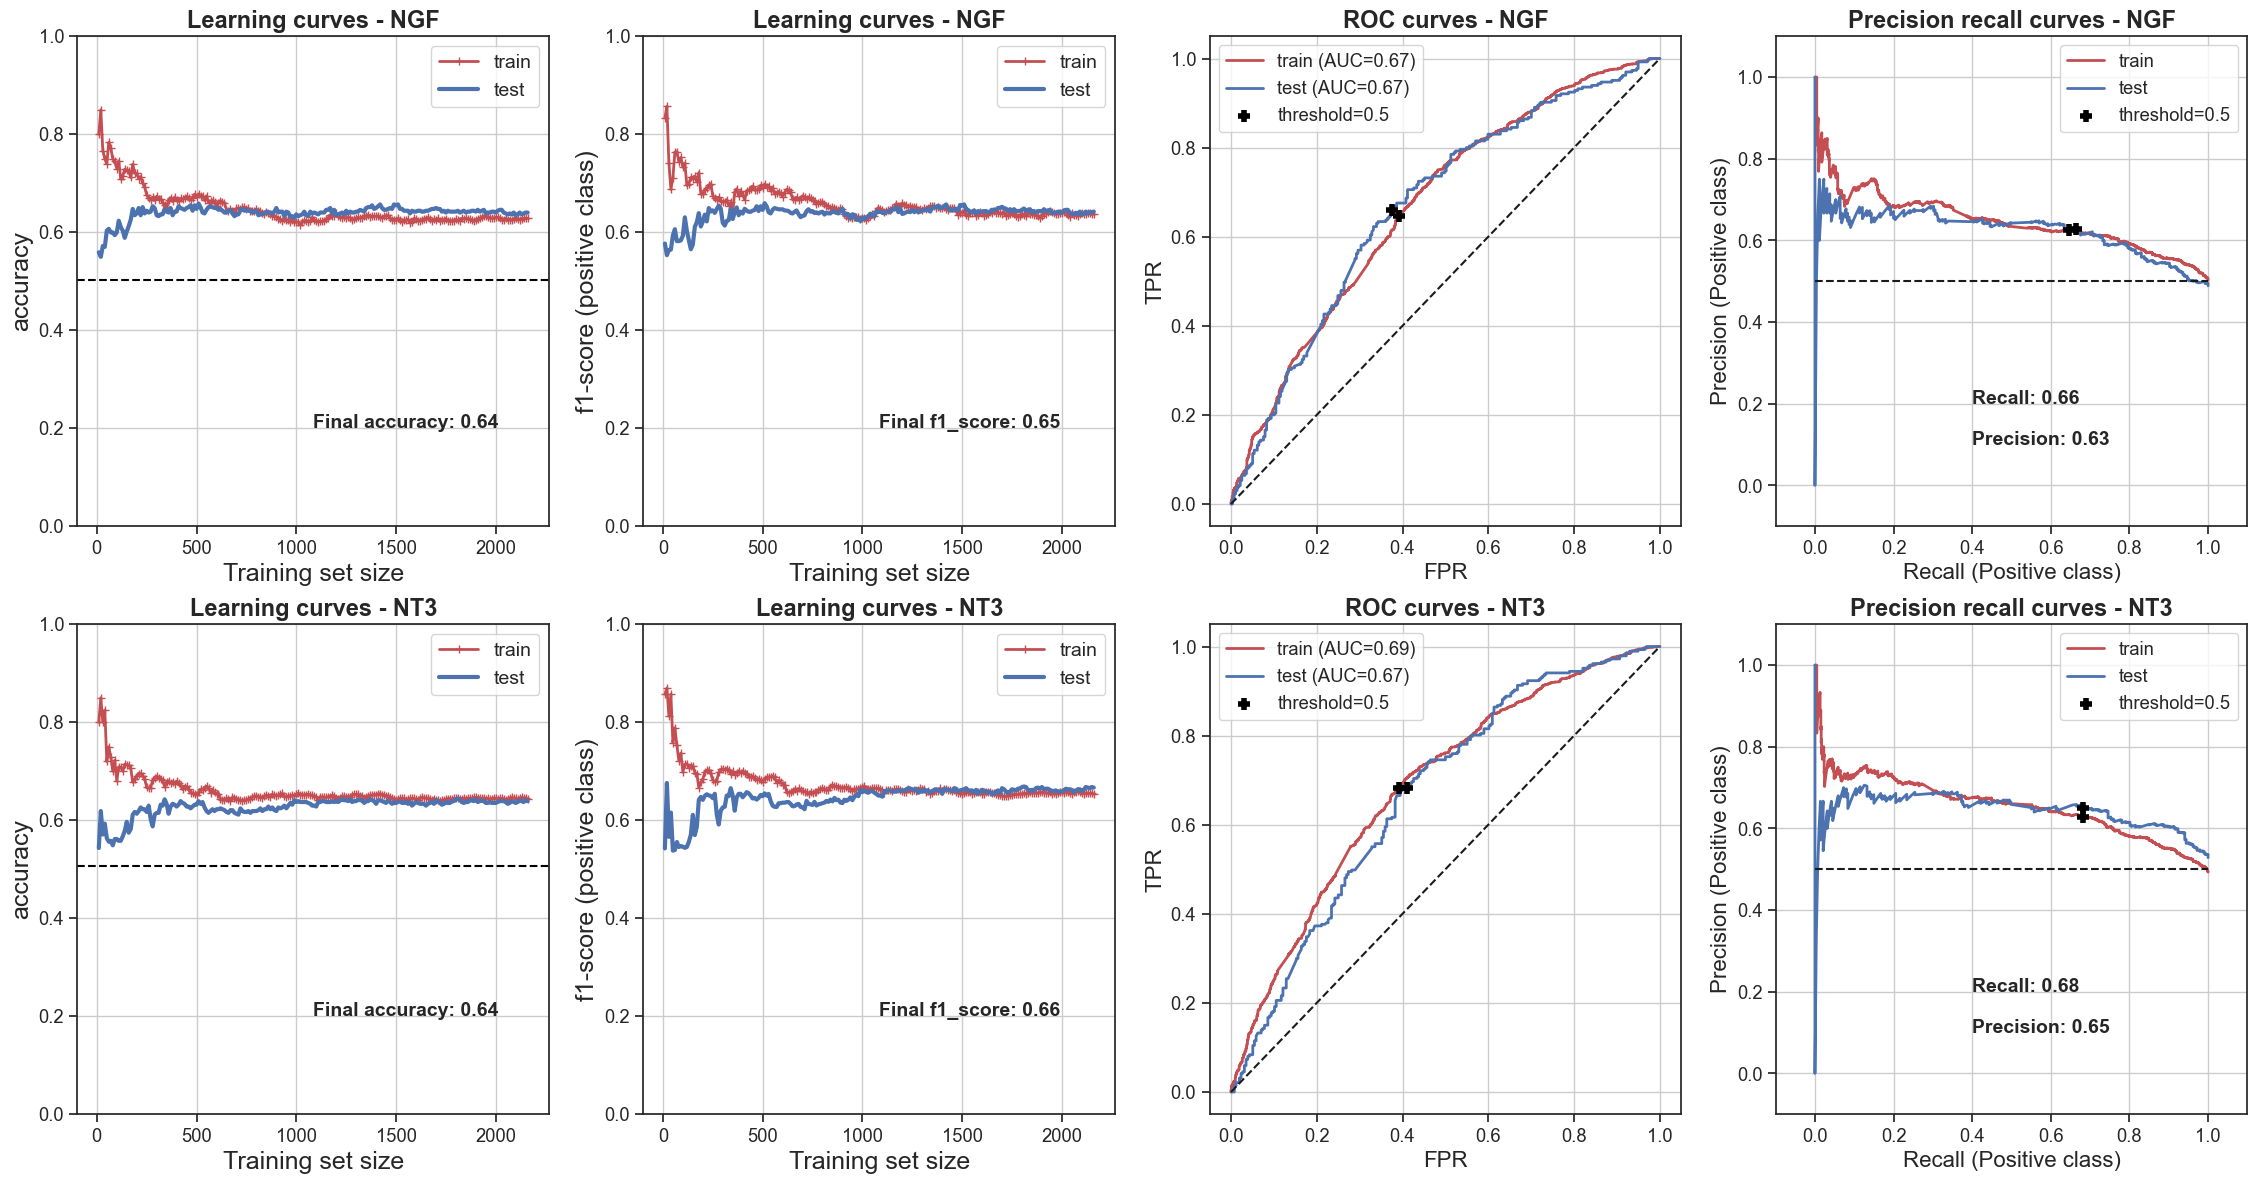

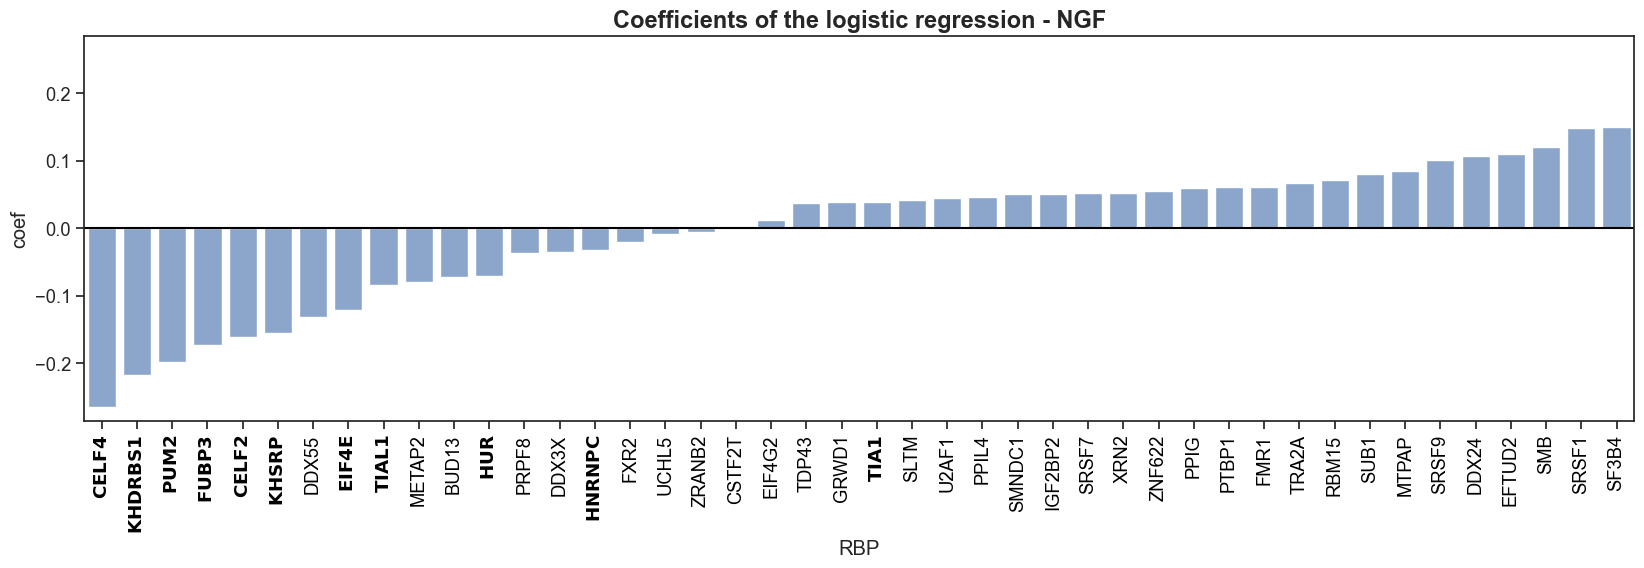

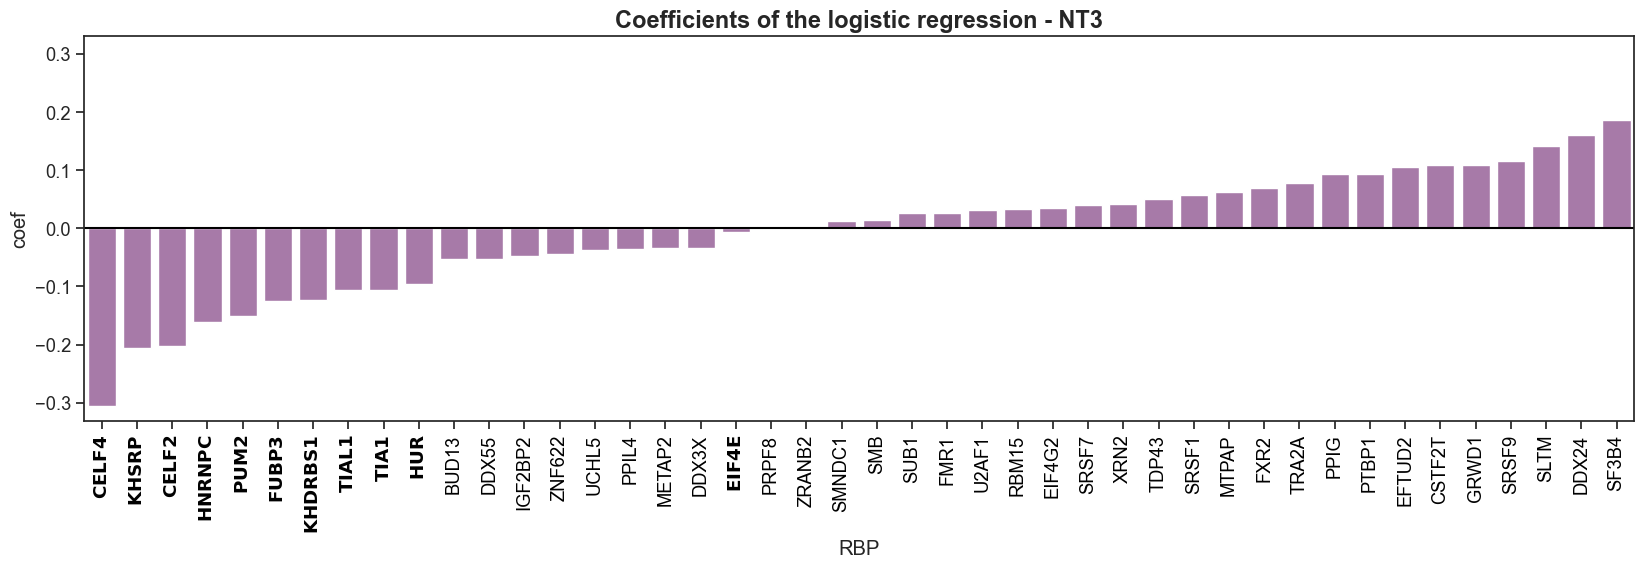

In [9]:
train_logistic_all_conditions(datasets_per_condition=datasets_per_condition,
                              dataset_key='dataset',
                              include_plots=True,
                              conditions_names=conditions_names, 
                              feature_name_col='RBP',
                              palette=palette,
                              step_learning=10,
                              negative_regulators=negative_regulators, 
                              parameters_lr=parameters_lr)

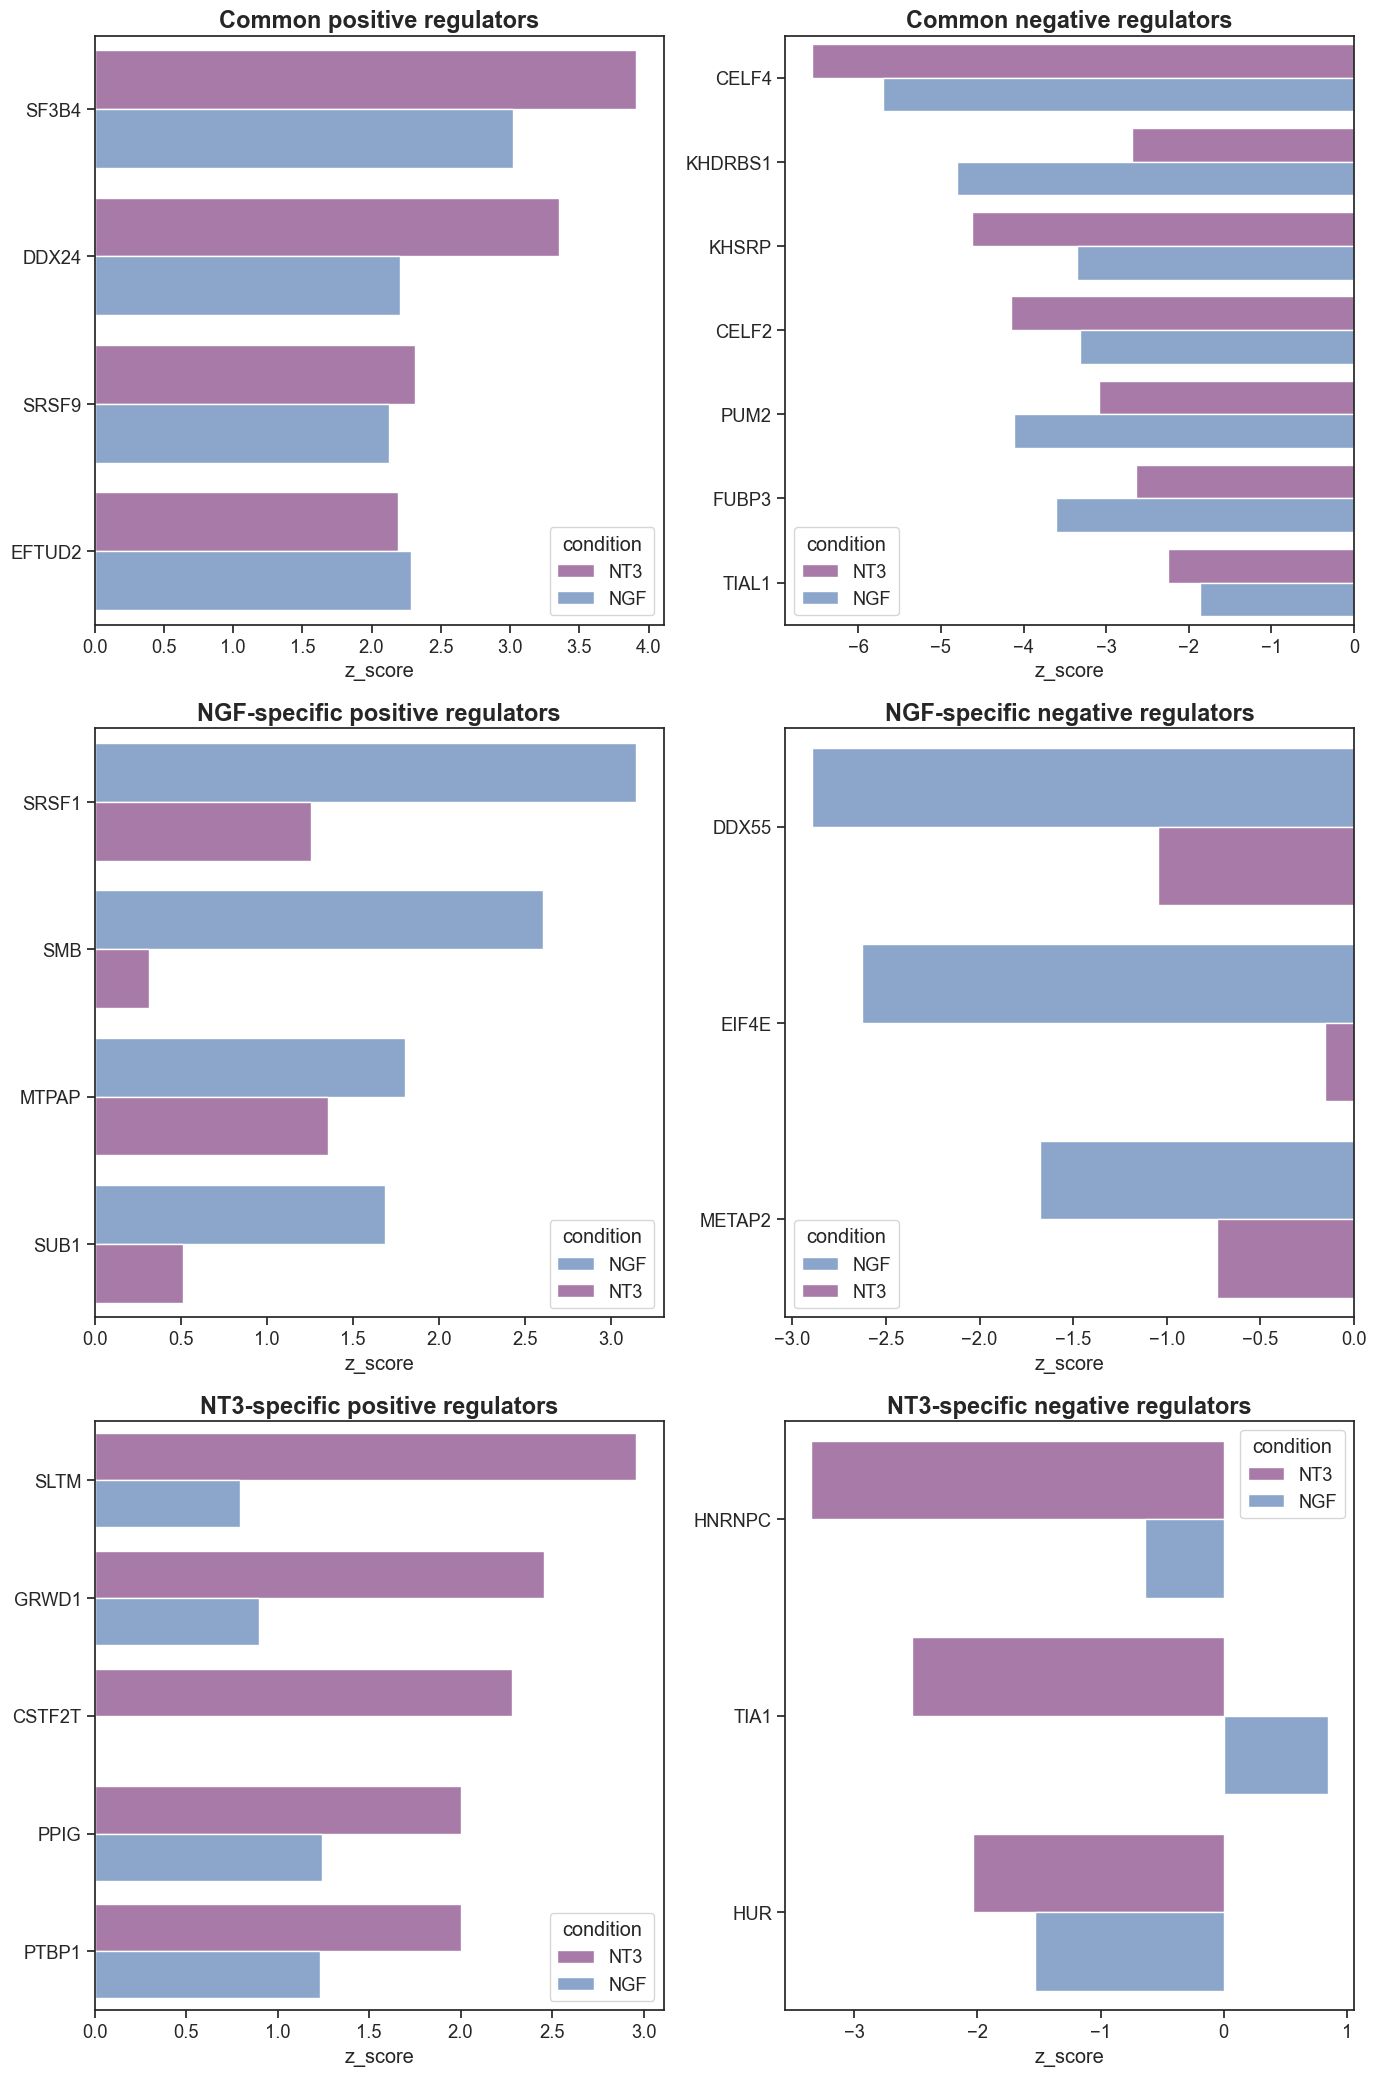

In [10]:
dic_summary = plot_common_and_specific_regulators_zscores(datasets_per_condition,
                                            feature_name='RBP',
                                         dataset_key='dataset',
                                         model_key='logit_model',
                                         conditions_names=conditions_names, 
                                         model1_name='NGF', 
                                         model2_name='NT3',
                                         n_permutations=2000,
                                         sig_threshold=0.05,
                                         palette_conditions=palette_conditions,
                                         return_groups=True)

In [11]:
nb_shapley = 5

100%|██████████| 5/5 [00:42<00:00,  8.47s/it]


100%|██████████| 5/5 [00:42<00:00,  8.51s/it]


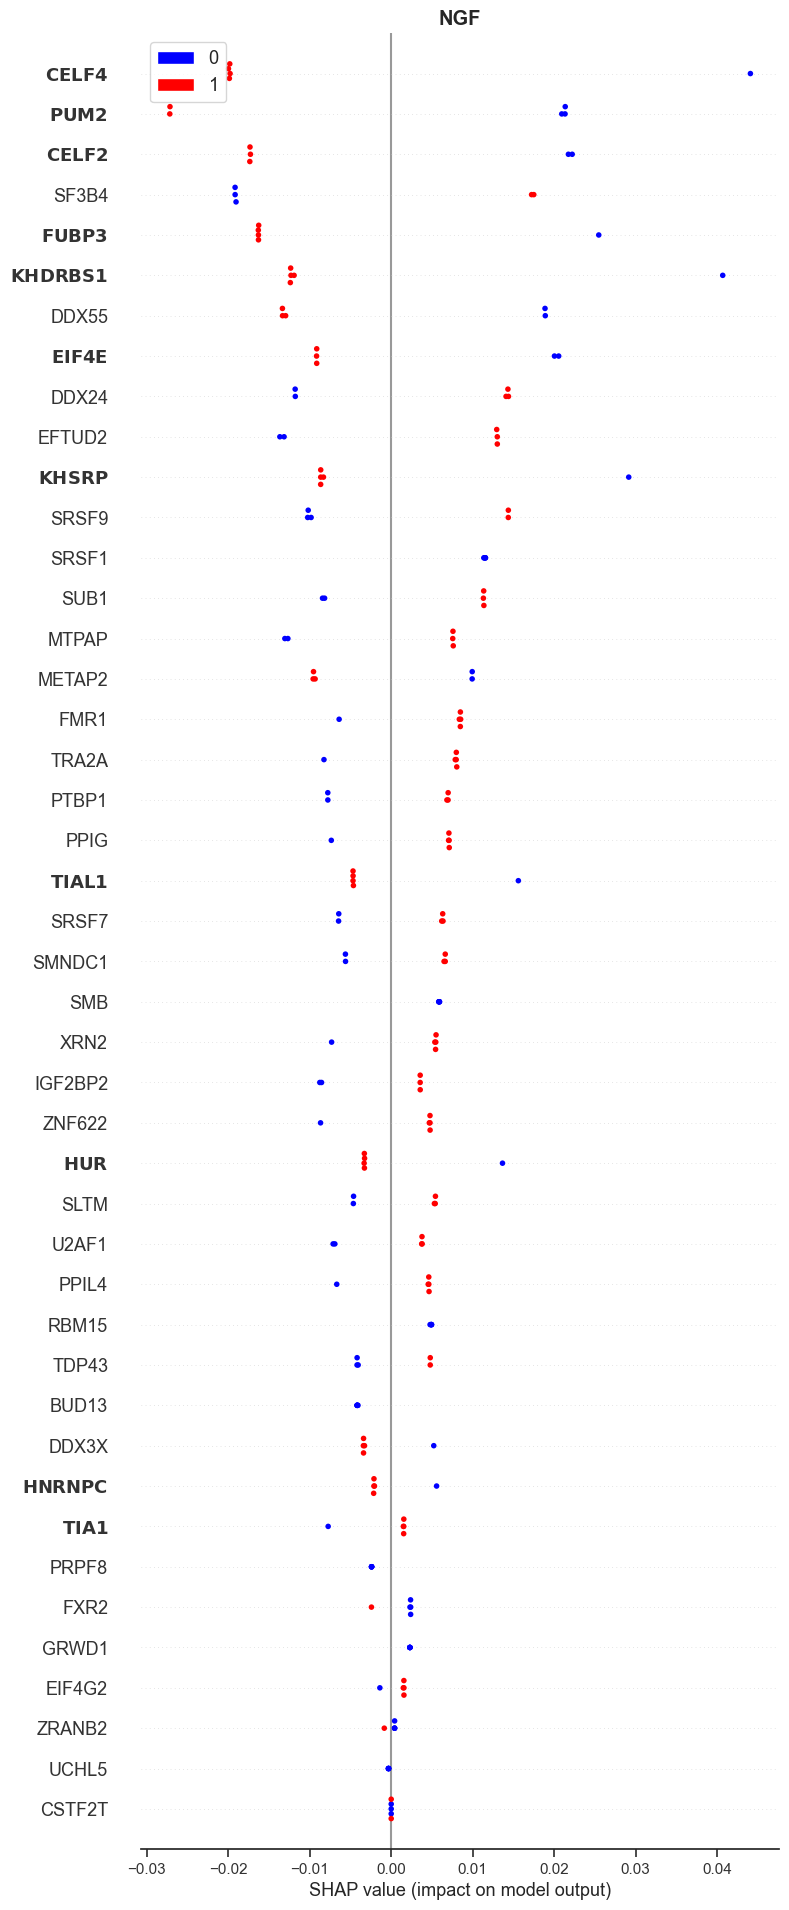

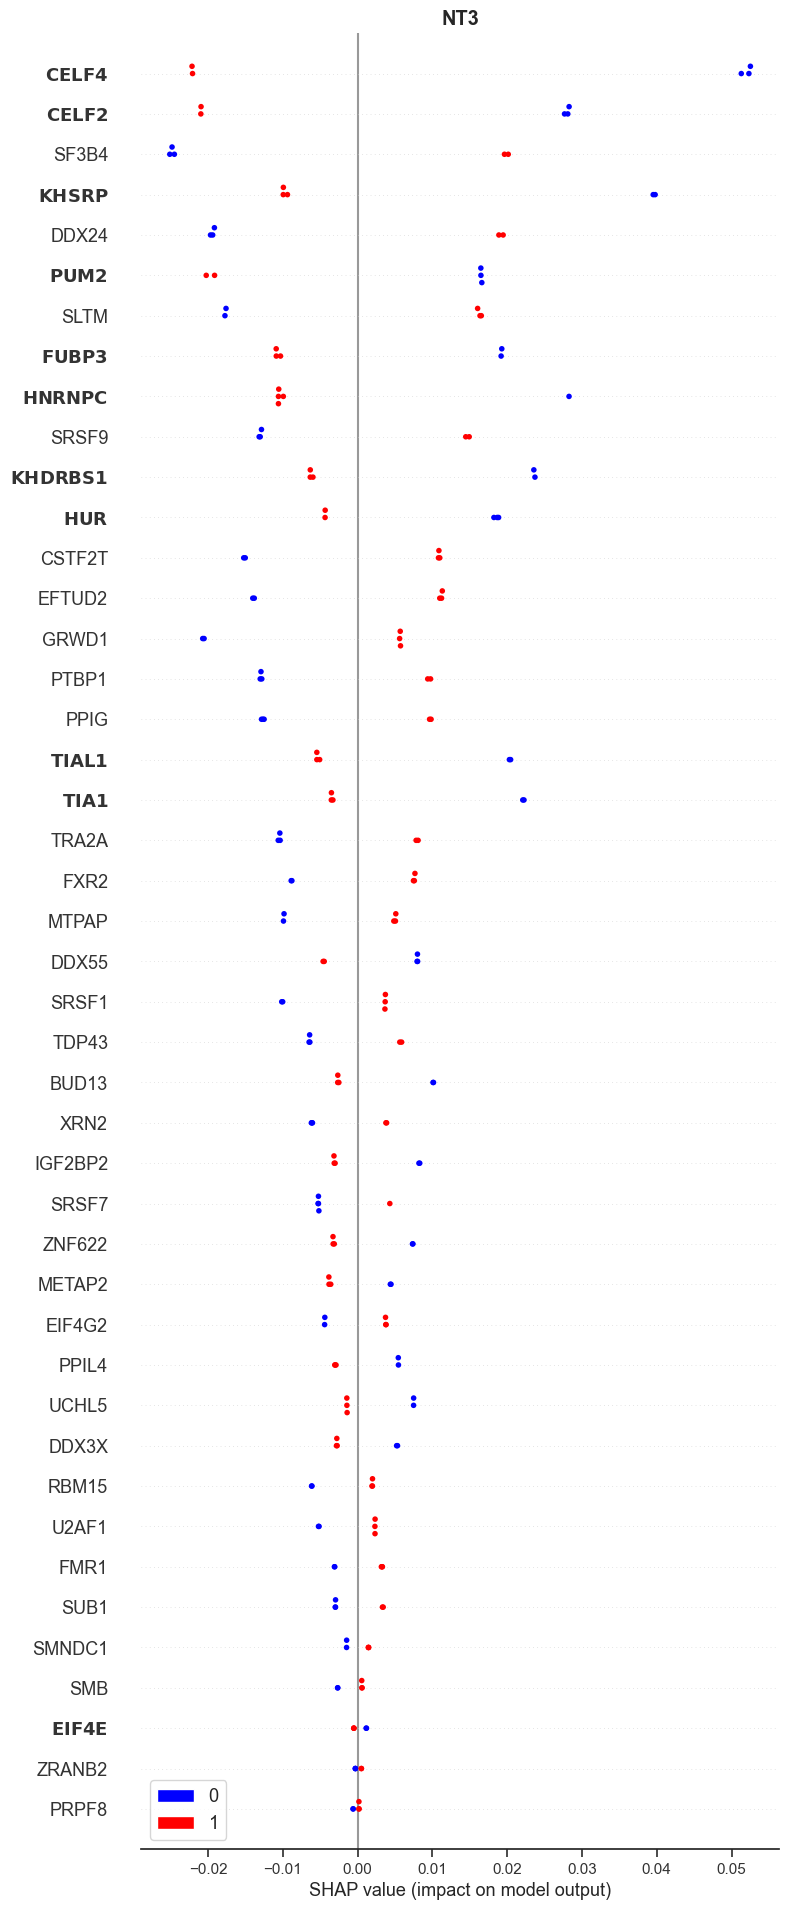

In [13]:

for i, condition in enumerate(datasets_per_condition.keys()):
    model = datasets_per_condition[condition]['logit_model']
    X_train, X_test, y_train, y_test = datasets_per_condition[condition]['dataset'].values()
    feature_names = datasets_per_condition[condition]['dataset']['X_train'].columns

    shap.initjs()
    
    # Initialize the explainer
    explainer = KernelExplainer(model.predict_proba, X_train, n_jobs=4)
    
    # Compute the shapley values
    shap_values = explainer.shap_values(X_test[:nb_shapley])
    
    plot_shapley(shap_values=shap_values, 
                 X_test=X_test[:nb_shapley], 
                 feature_names=feature_names, 
                 max_display=X_test.shape[1], 
                 show=False,
                 class_label=1,
                 negative_regulators=negative_regulators, 
                 condition_name=conditions_names[i], 
                 beeswarm_only=True)

## 5. Model 2: The 33 RBPs positive regulators of localization (M2)

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NGF -----------------
              precision    recall  f1-score   support

           0       0.58      0.63      0.60       277
           1       0.57      0.52      0.54       265

    accuracy                           0.57       542
   macro avg       0.57      0.57      0.57       542
weighted avg       0.57      0.57      0.57       542

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NT3 -----------------
              precision    recall  f1-score   support

           0       0.52      0.59      0.56       256
           1       0.59      0.52      0.55       287

    accuracy                           0.55       543
   macro avg       0.56      0.56      0.55       543
weighted avg       0.56      0.55      0.55       543



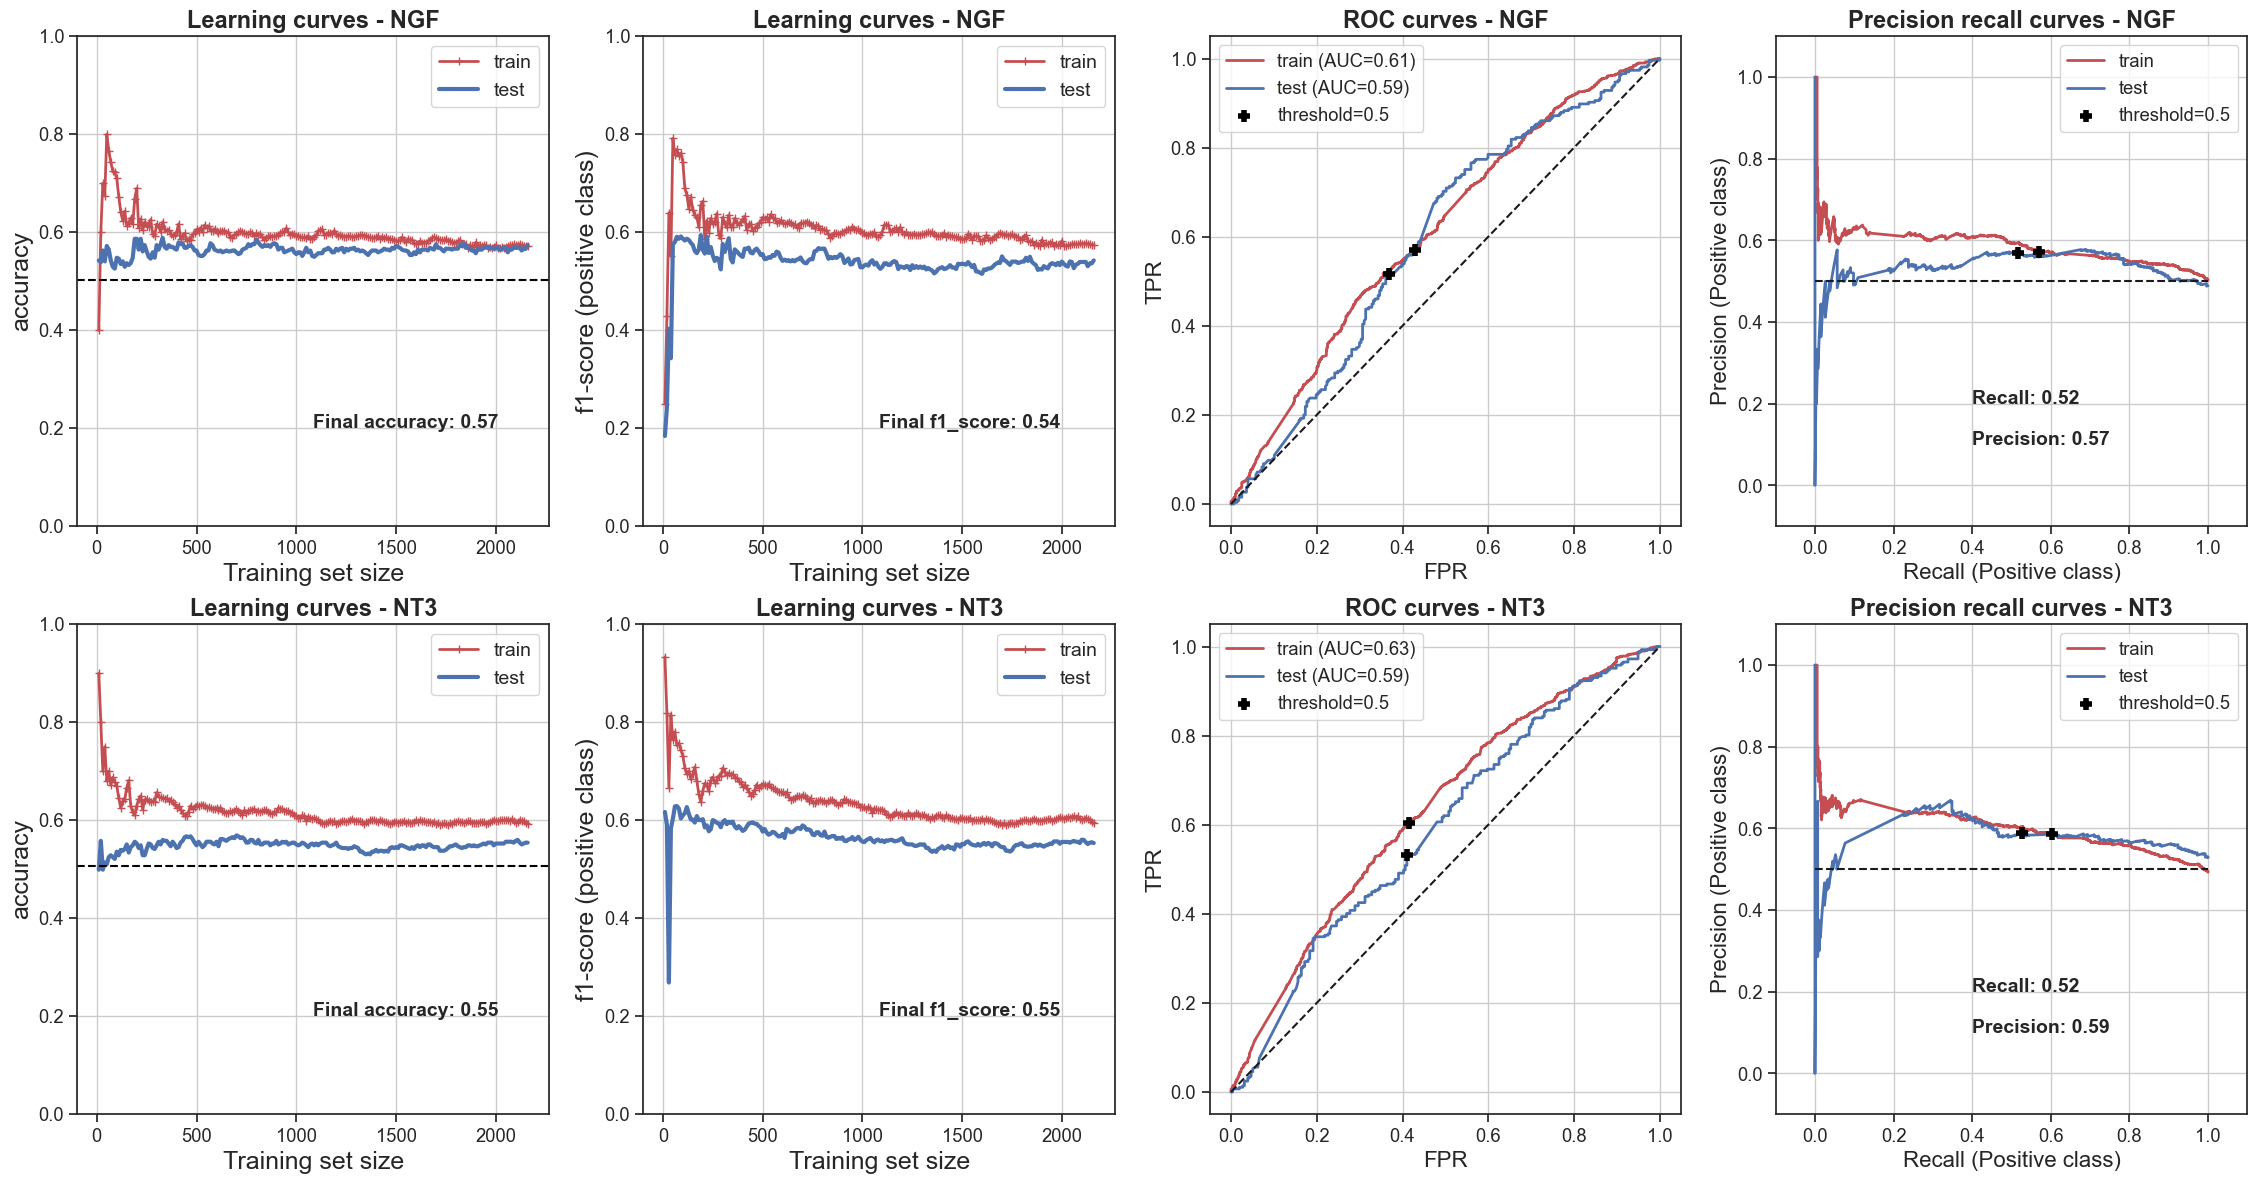

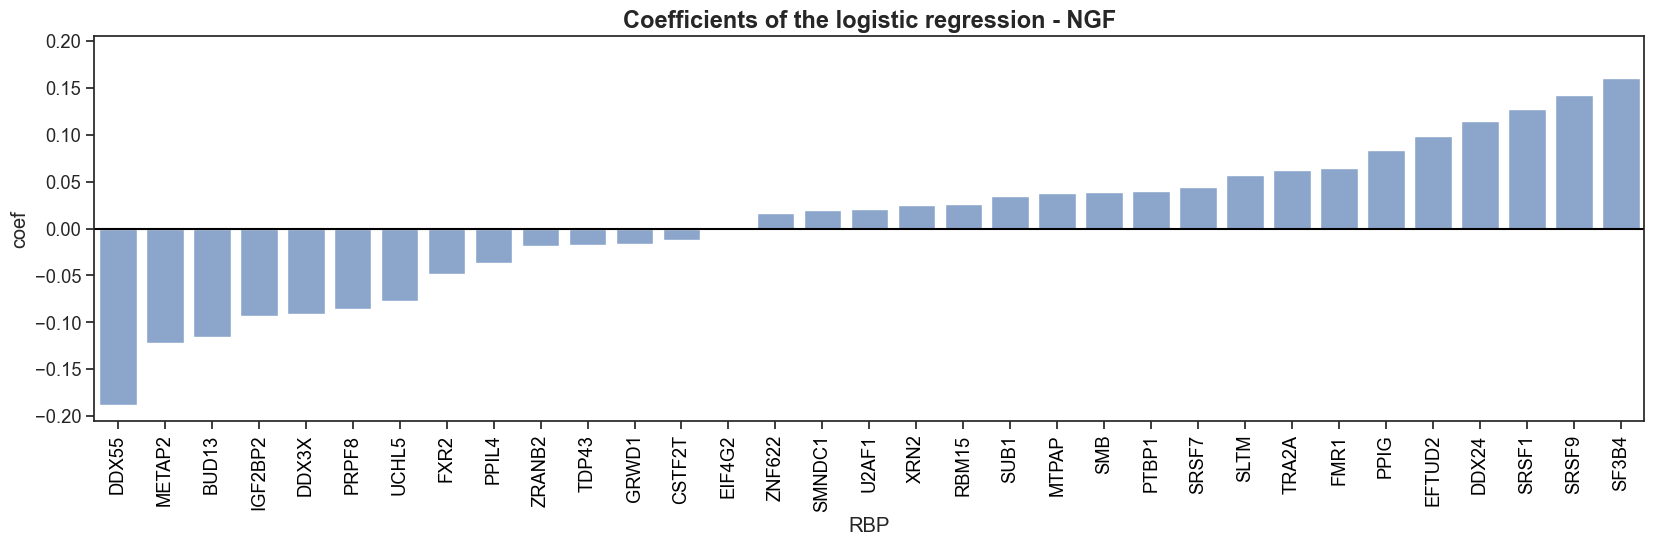

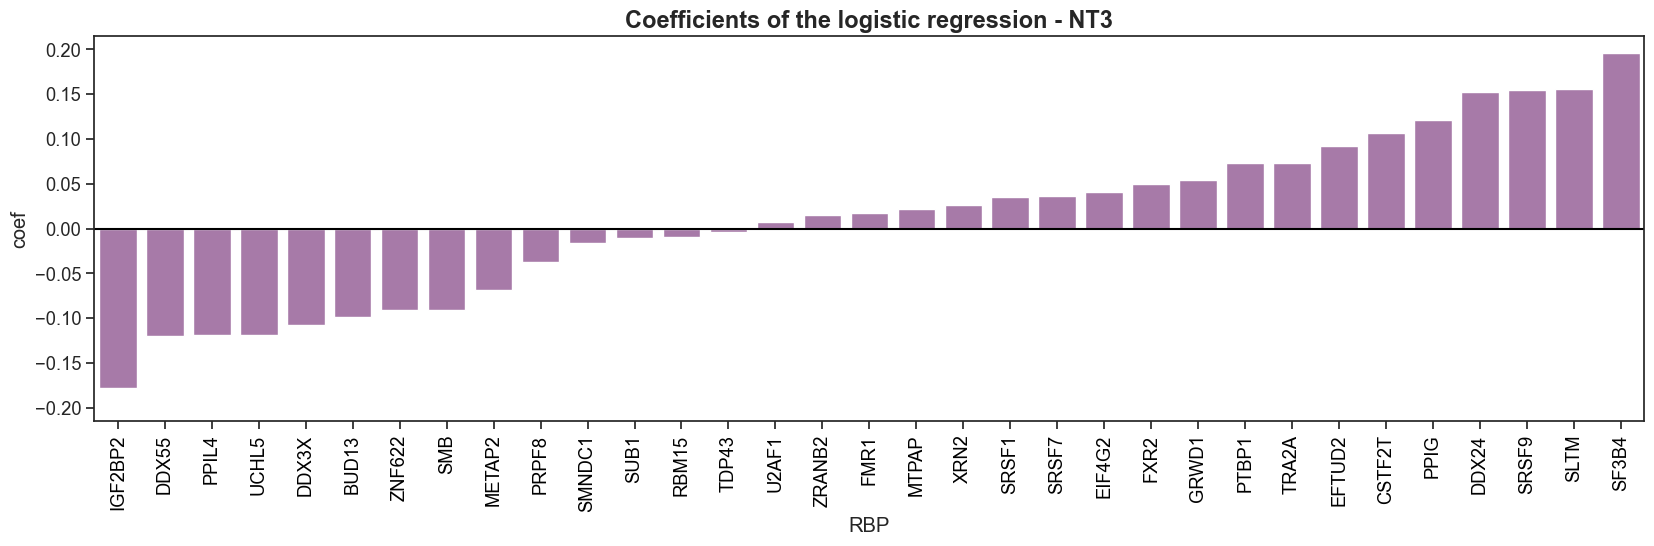

In [14]:
train_logistic_all_conditions(datasets_per_condition=datasets_per_condition,
                              dataset_key='dataset_positive',
                              suffix='_positive',
                              include_plots=True,
                              conditions_names=conditions_names, 
                              palette=palette,
                              step_learning=10,
                              feature_name_col='RBP',
                              negative_regulators=negative_regulators, 
                              parameters_lr=parameters_lr)

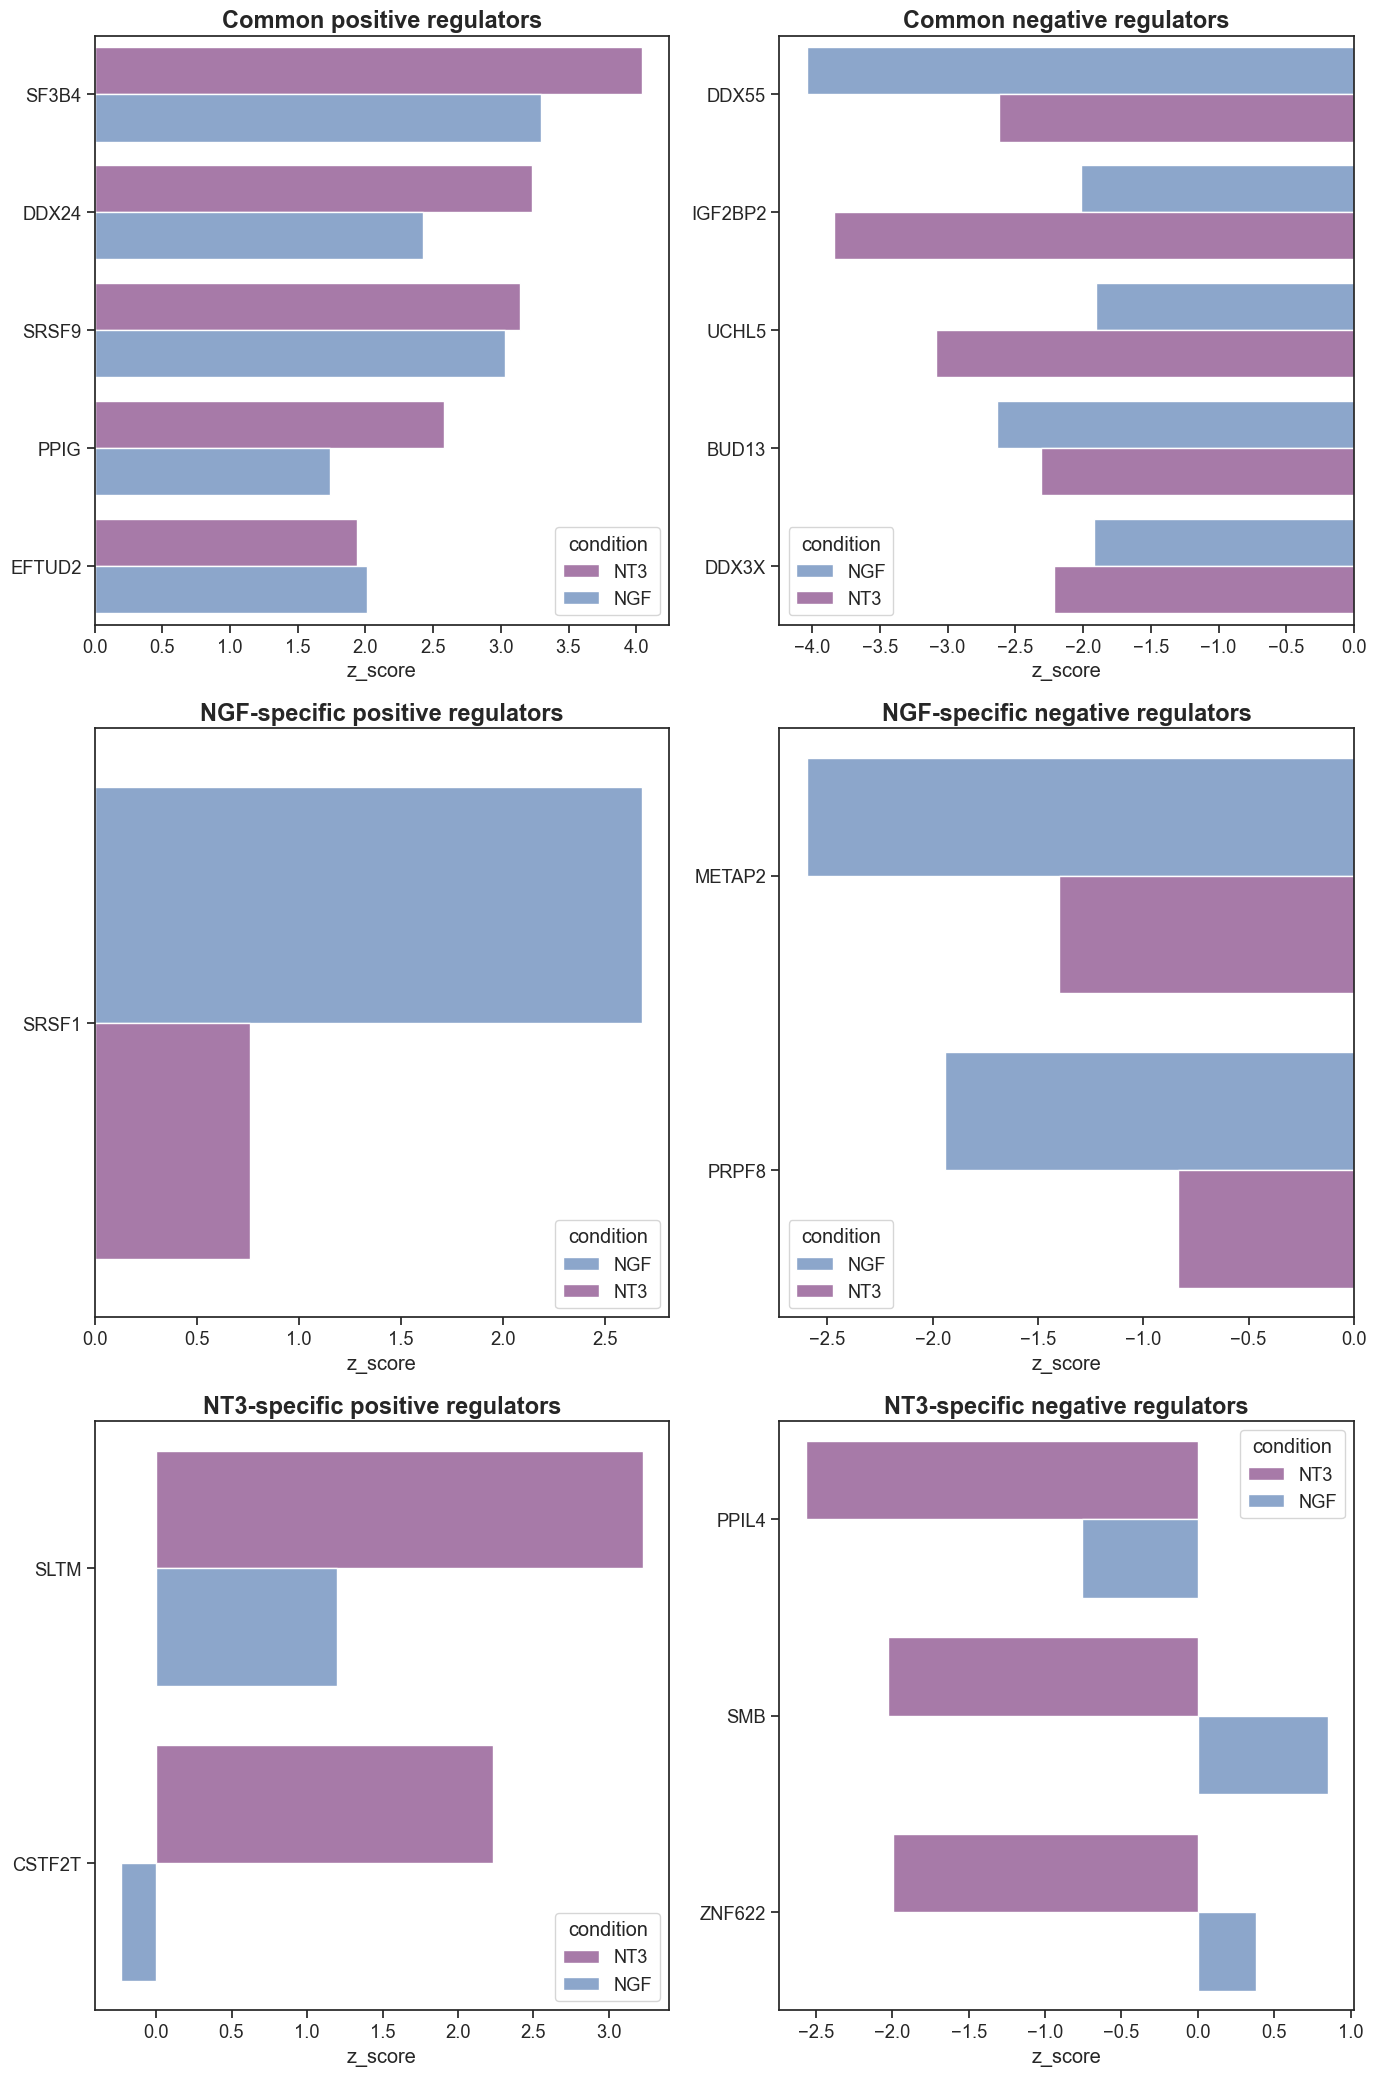

In [15]:
plot_common_and_specific_regulators_zscores(datasets_per_condition,
                                            feature_name='RBP',
                                         dataset_key='dataset_positive',
                                         model_key='logit_model_positive',
                                         conditions_names=conditions_names, 
                                         model1_name='NGF', 
                                         model2_name='NT3',
                                         n_permutations=2000,
                                         sig_threshold=0.05,
                                         palette_conditions=palette_conditions)

## 6. Model 3: The 11 RBPs negative regulators of localization (M3)

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NGF -----------------
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       277
           1       0.61      0.55      0.58       265

    accuracy                           0.61       542
   macro avg       0.61      0.61      0.61       542
weighted avg       0.61      0.61      0.61       542

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NT3 -----------------
              precision    recall  f1-score   support

           0       0.58      0.69      0.63       256
           1       0.67      0.56      0.61       287

    accuracy                           0.62       543
   macro avg       0.63      0.62      0.62       543
weighted avg       0.63      0.62      0.62       543



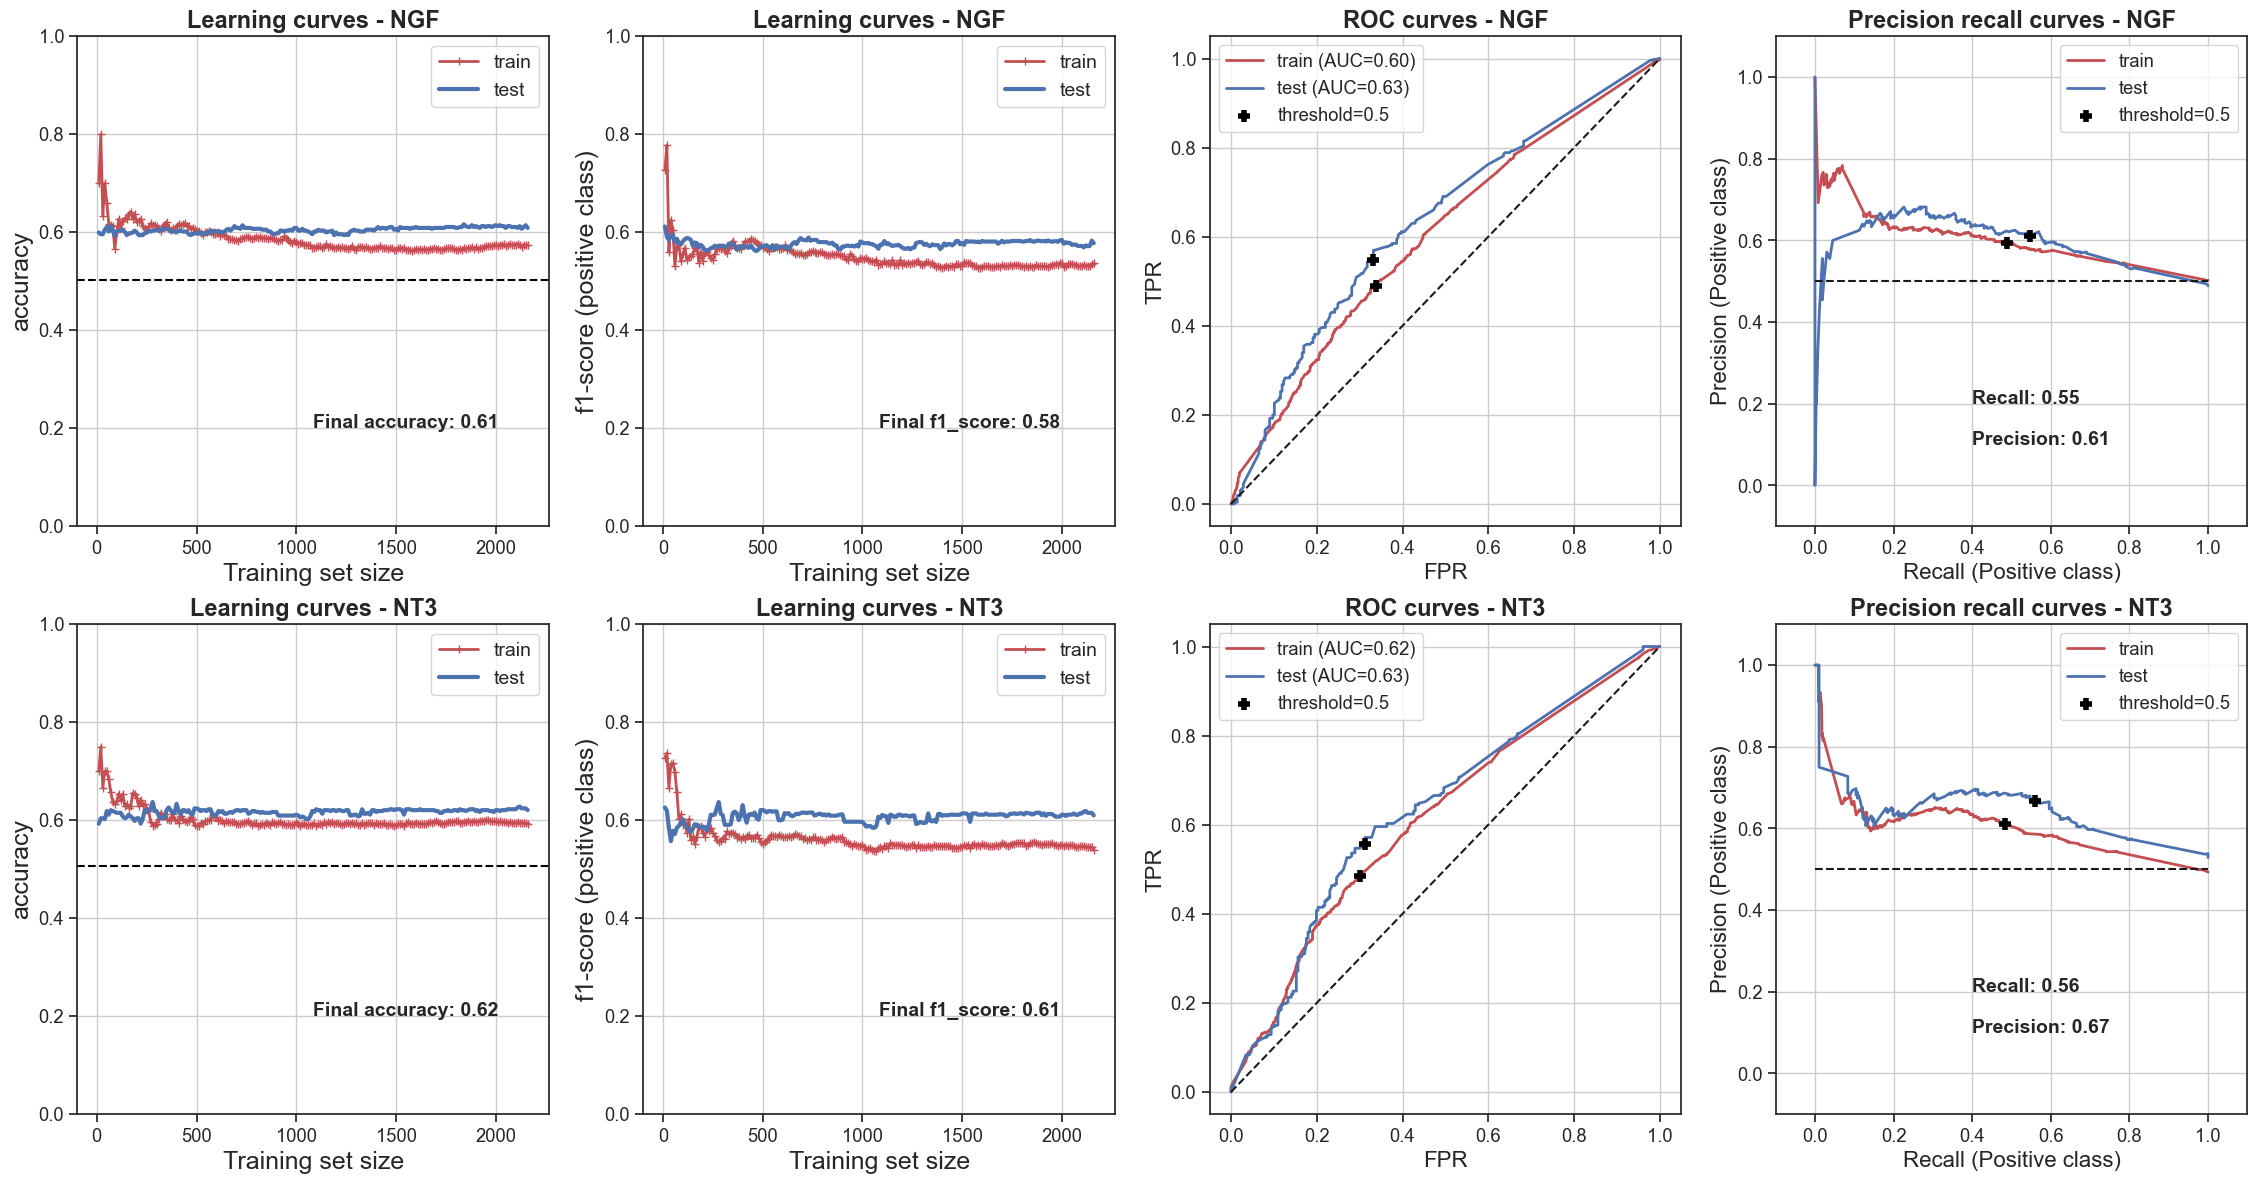

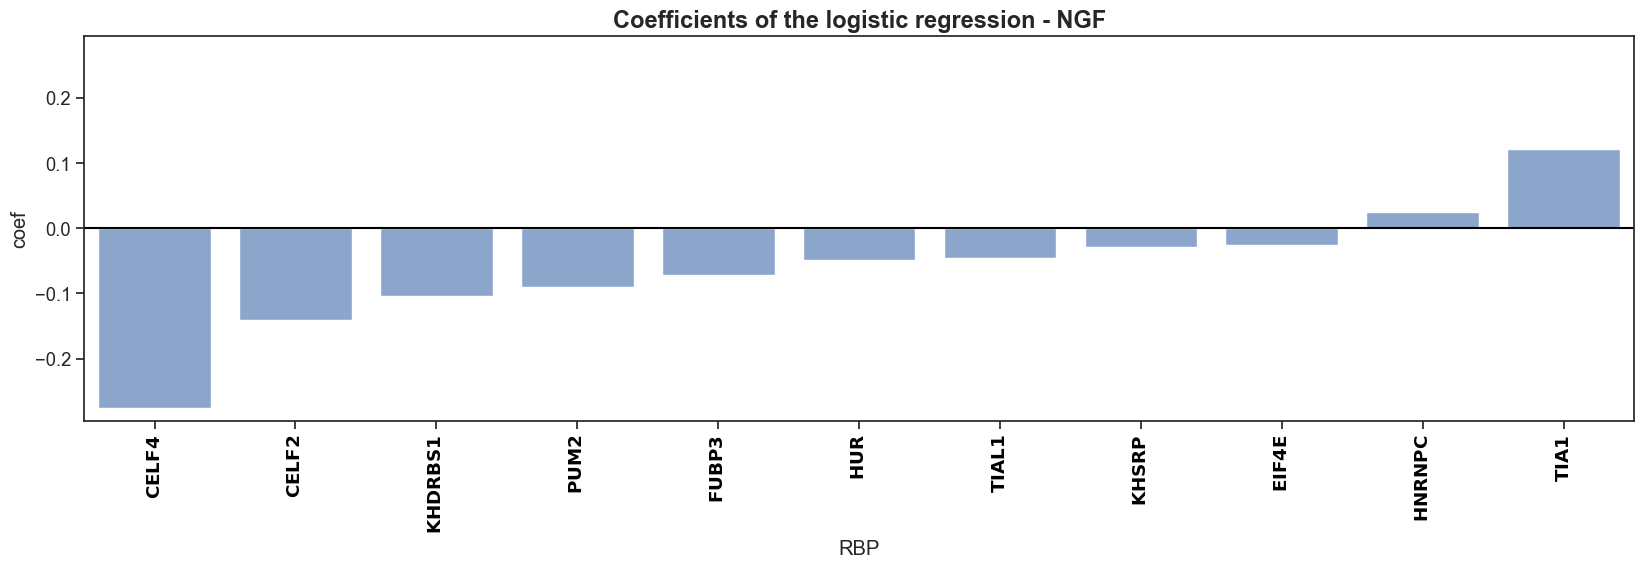

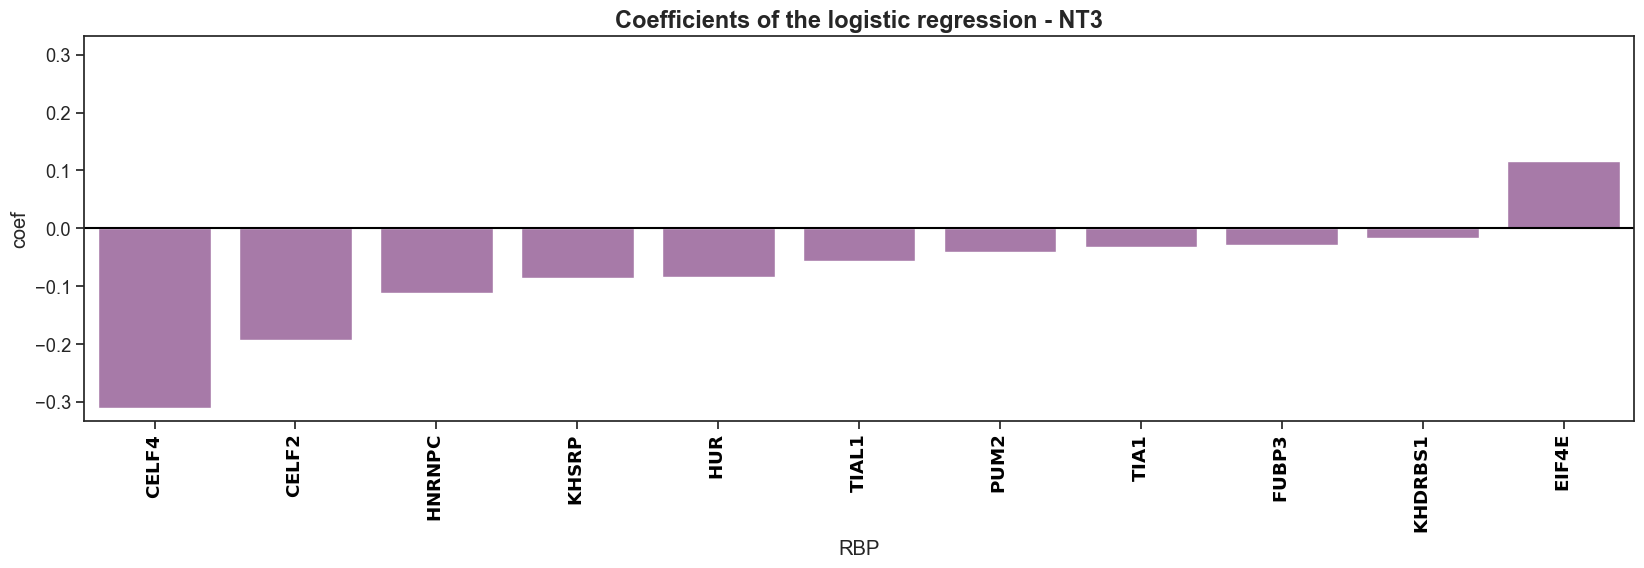

In [16]:
train_logistic_all_conditions(datasets_per_condition=datasets_per_condition,
                              dataset_key='dataset_negative',
                              suffix='_negative',
                              include_plots=True,
                              conditions_names=conditions_names, 
                              palette=palette,
                              step_learning=10,
                              feature_name_col='RBP',
                              negative_regulators=negative_regulators,                               
                              parameters_lr=parameters_lr)

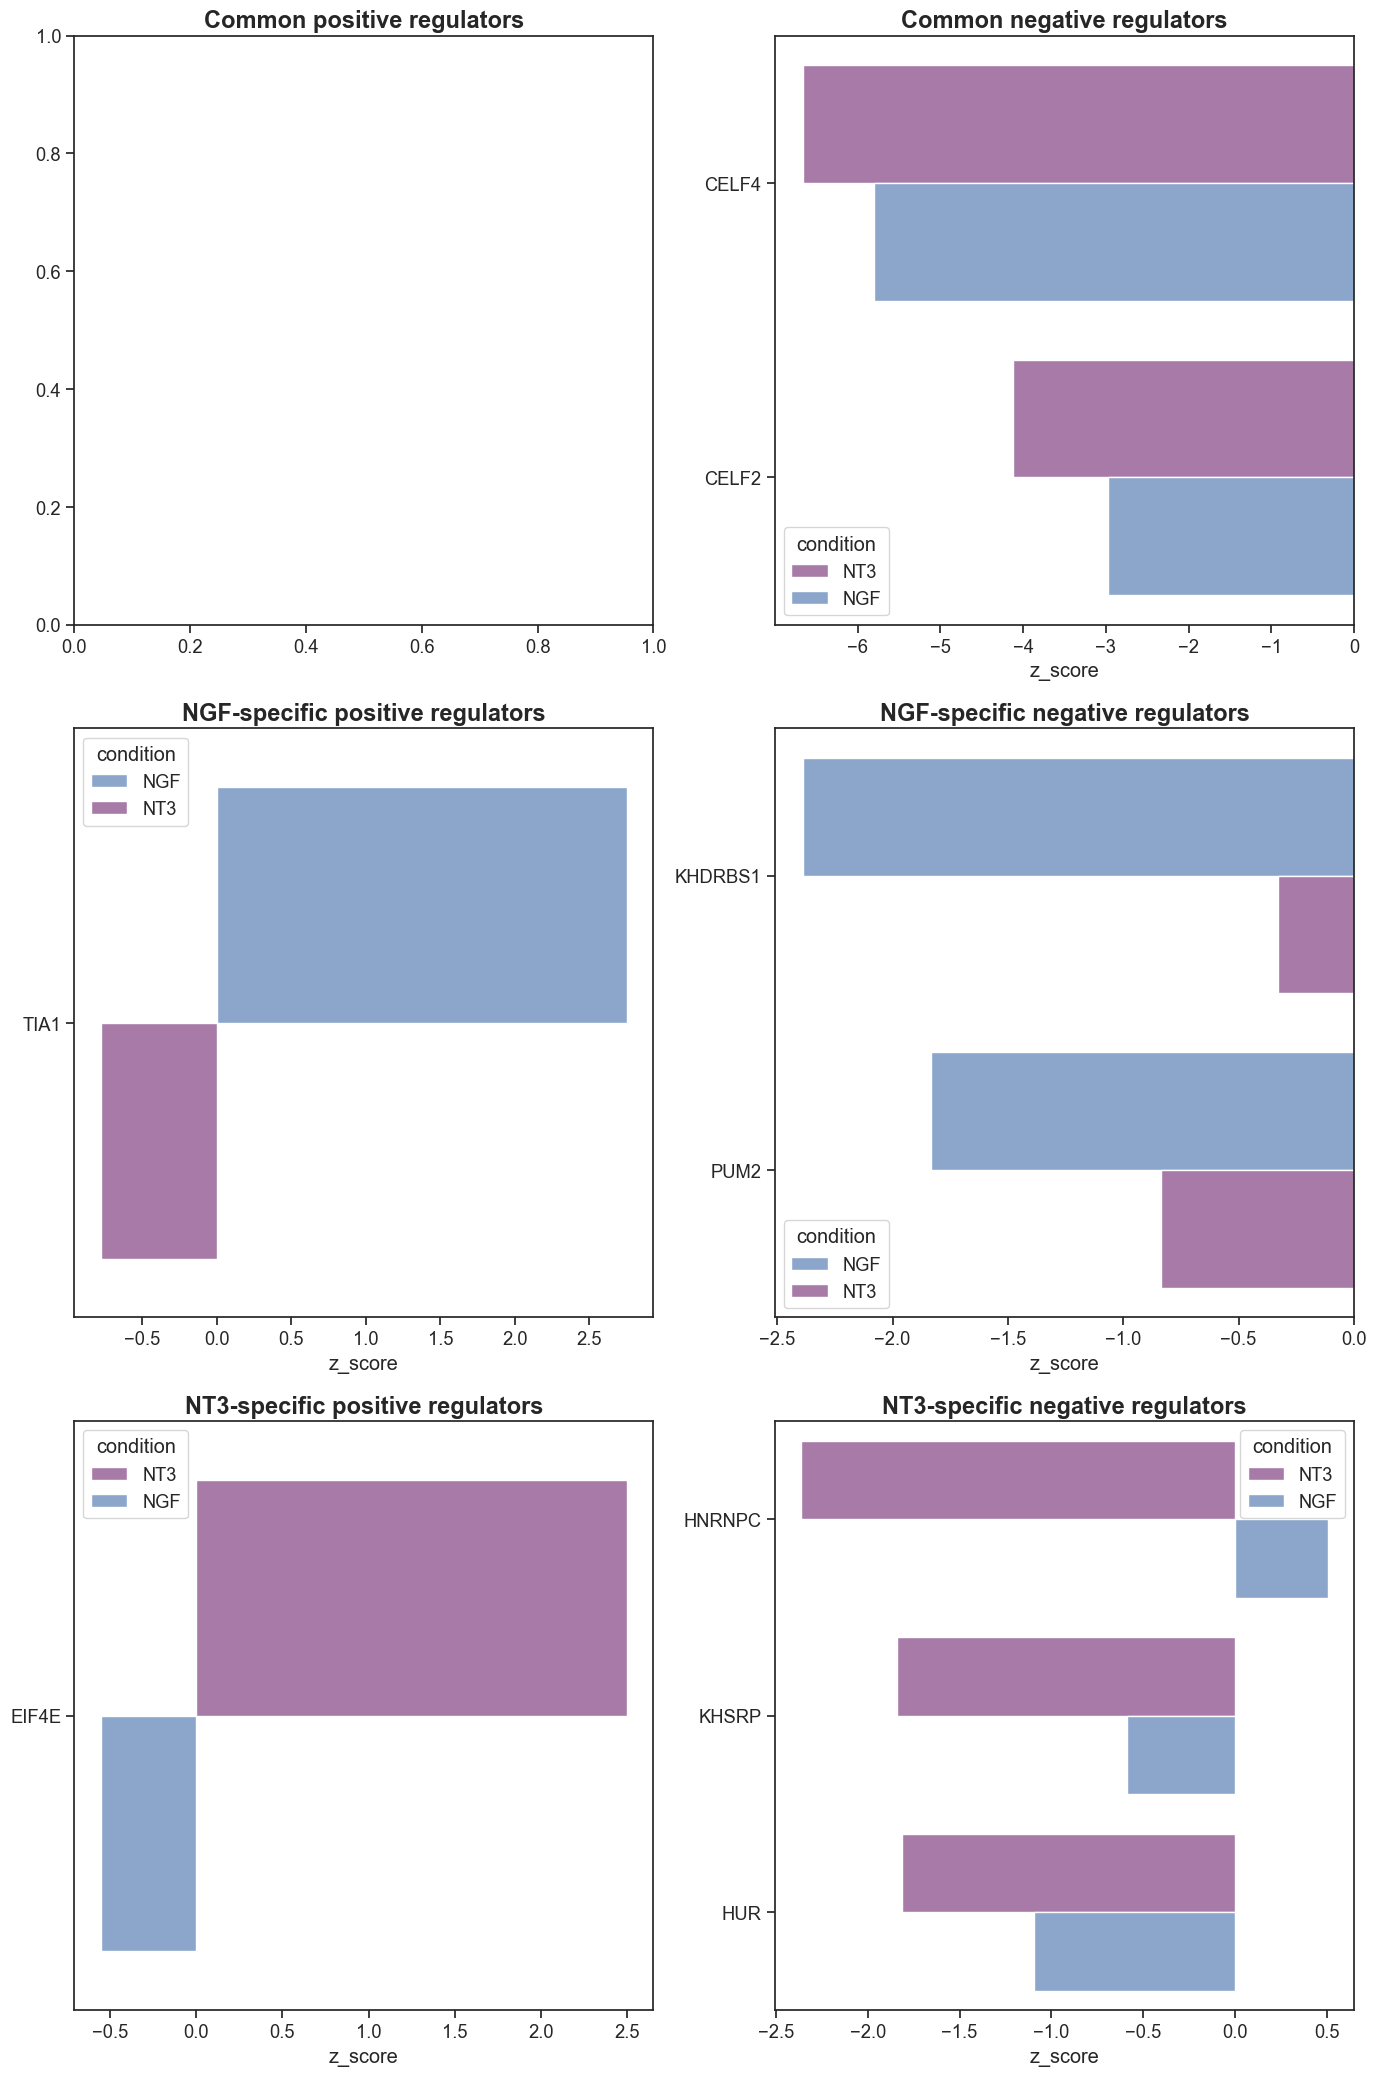

In [17]:
plot_common_and_specific_regulators_zscores(datasets_per_condition,
                                            feature_name='RBP',
                                         dataset_key='dataset_negative',
                                         model_key='logit_model_negative',
                                         conditions_names=conditions_names, 
                                         model1_name='NGF', 
                                         model2_name='NT3',
                                         n_permutations=2000,
                                         sig_threshold=0.05,
                                         palette_conditions=palette_conditions)

## 7. Model 4: The top 42 interactions between RBPs (M4)

### 7.1. Select the top 4 RBPs of each condition from M1

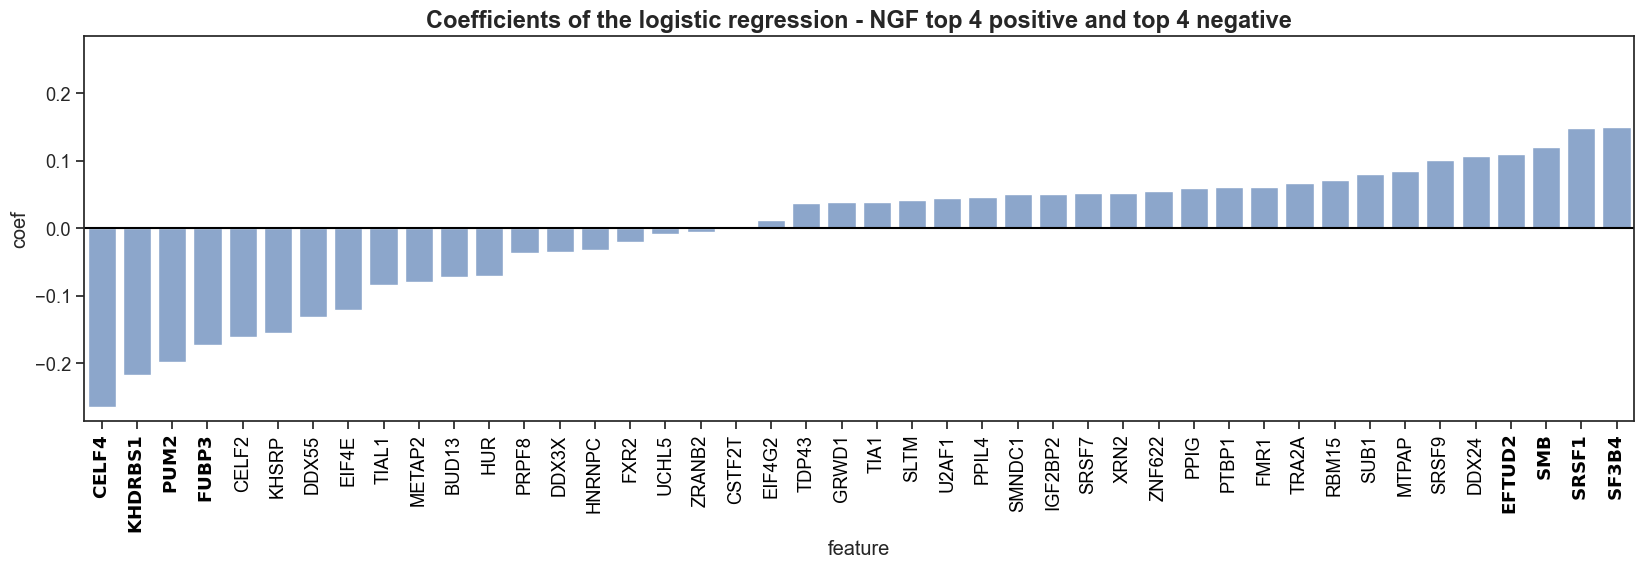

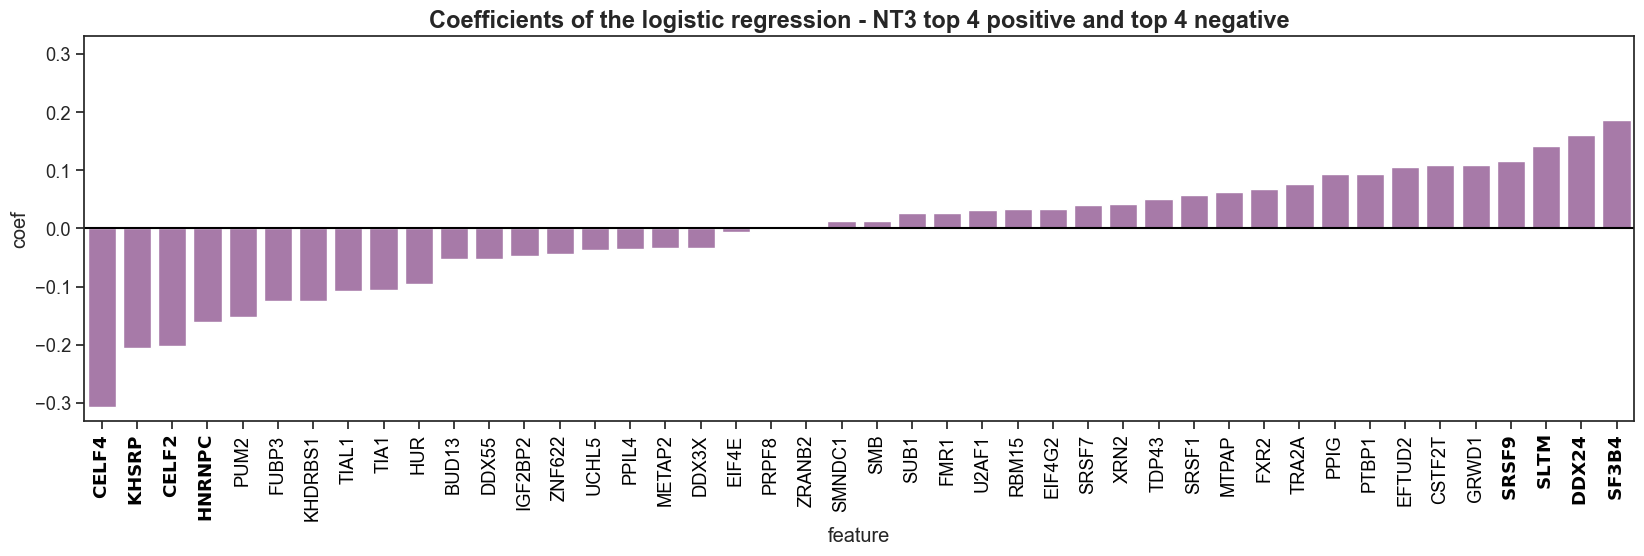

In [18]:
# for materials and methods 

nb_top = 4

for i, condition in enumerate(datasets_per_condition.keys()):
    top_features = list(datasets_per_condition[condition]['logit_coef'].sort_values('coef')[:nb_top].index)+list(datasets_per_condition[condition]['logit_coef'].sort_values('coef')[-nb_top:].index)
    plot_coefficients_from_logistic_model(datasets_per_condition[condition]['logit_model'], 
                            color=palette[condition], 
                            negative_regulators=top_features,
                            condition_name = conditions_names[i]+" top 4 positive and top 4 negative",
                            features_names=datasets_per_condition[condition]['dataset']['X_train'].columns)

## 7.2 Create the interaction terms

In [19]:
# top features to create interction terms
nb_top = 4


## Add interactions between top 4 positive and top 4 negative features of each condition
top_features_pos = []
top_features_neg = []

for condition in datasets_per_condition.keys():
    coeff = datasets_per_condition[condition]['logit_coef'].reset_index().rename(columns={'index': 'RBP'}).sort_values('coef')
    top_features_pos += list(coeff.reindex(coeff.coef.sort_values(ascending=False).index).head(nb_top)['RBP'])
    top_features_neg += list(coeff.reindex(coeff.coef.sort_values(ascending=True).index).head(nb_top)['RBP'])
    
top_features_pos = list(set(top_features_pos))
top_features_neg = list(set(top_features_neg))
combs = list(combinations(list(top_features_neg), 2))  + list(combinations(list(top_features_pos), 2))
combs = list(set(list(combs)))
combs = list(set(tuple(sorted(comb)) for comb in combs))
print(combs)

[('FUBP3', 'PUM2'), ('SF3B4', 'SMB'), ('SF3B4', 'SLTM'), ('SLTM', 'SMB'), ('DDX24', 'SLTM'), ('DDX24', 'SMB'), ('CELF2', 'KHDRBS1'), ('CELF4', 'KHDRBS1'), ('EFTUD2', 'SRSF9'), ('EFTUD2', 'SF3B4'), ('FUBP3', 'KHSRP'), ('CELF2', 'PUM2'), ('EFTUD2', 'SRSF1'), ('HNRNPC', 'KHDRBS1'), ('SMB', 'SRSF9'), ('FUBP3', 'HNRNPC'), ('CELF4', 'PUM2'), ('KHSRP', 'PUM2'), ('CELF2', 'CELF4'), ('DDX24', 'EFTUD2'), ('SF3B4', 'SRSF9'), ('CELF2', 'FUBP3'), ('SMB', 'SRSF1'), ('HNRNPC', 'PUM2'), ('SLTM', 'SRSF9'), ('CELF4', 'FUBP3'), ('DDX24', 'SRSF9'), ('KHDRBS1', 'PUM2'), ('DDX24', 'SF3B4'), ('SF3B4', 'SRSF1'), ('CELF2', 'KHSRP'), ('EFTUD2', 'SMB'), ('CELF4', 'KHSRP'), ('EFTUD2', 'SLTM'), ('CELF2', 'HNRNPC'), ('SLTM', 'SRSF1'), ('DDX24', 'SRSF1'), ('FUBP3', 'KHDRBS1'), ('CELF4', 'HNRNPC'), ('HNRNPC', 'KHSRP'), ('KHDRBS1', 'KHSRP'), ('SRSF1', 'SRSF9')]


In [20]:
for condition in datasets_per_condition.keys():
    X_train, X_test, y_train, y_test = datasets_per_condition[condition]['dataset'].values()

    X_train_int, X_test_int, y_train_int, y_test_int = create_interaction_dataset_from_list(X_train, 
                                                                                            X_test,
                                                                                            y_train,
                                                                                            y_test,
                                                                                            list_interactions=combs,
                                                                                            keep_old=False)

    datasets_per_condition[condition]['dataset_with_interactions'] = {'X_train': X_train_int, 
                                                                    'X_test': X_test_int, 
                                                                    'y_train': y_train_int, 
                                                                    'y_test': y_test_int}


Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NGF -----------------
              precision    recall  f1-score   support

           0       0.66      0.56      0.61       277
           1       0.60      0.71      0.65       265

    accuracy                           0.63       542
   macro avg       0.63      0.63      0.63       542
weighted avg       0.63      0.63      0.63       542

Fitting 20 folds for each of 15 candidates, totalling 300 fits
----------------- NT3 -----------------
              precision    recall  f1-score   support

           0       0.63      0.56      0.59       256
           1       0.64      0.70      0.67       287

    accuracy                           0.64       543
   macro avg       0.64      0.63      0.63       543
weighted avg       0.64      0.64      0.64       543



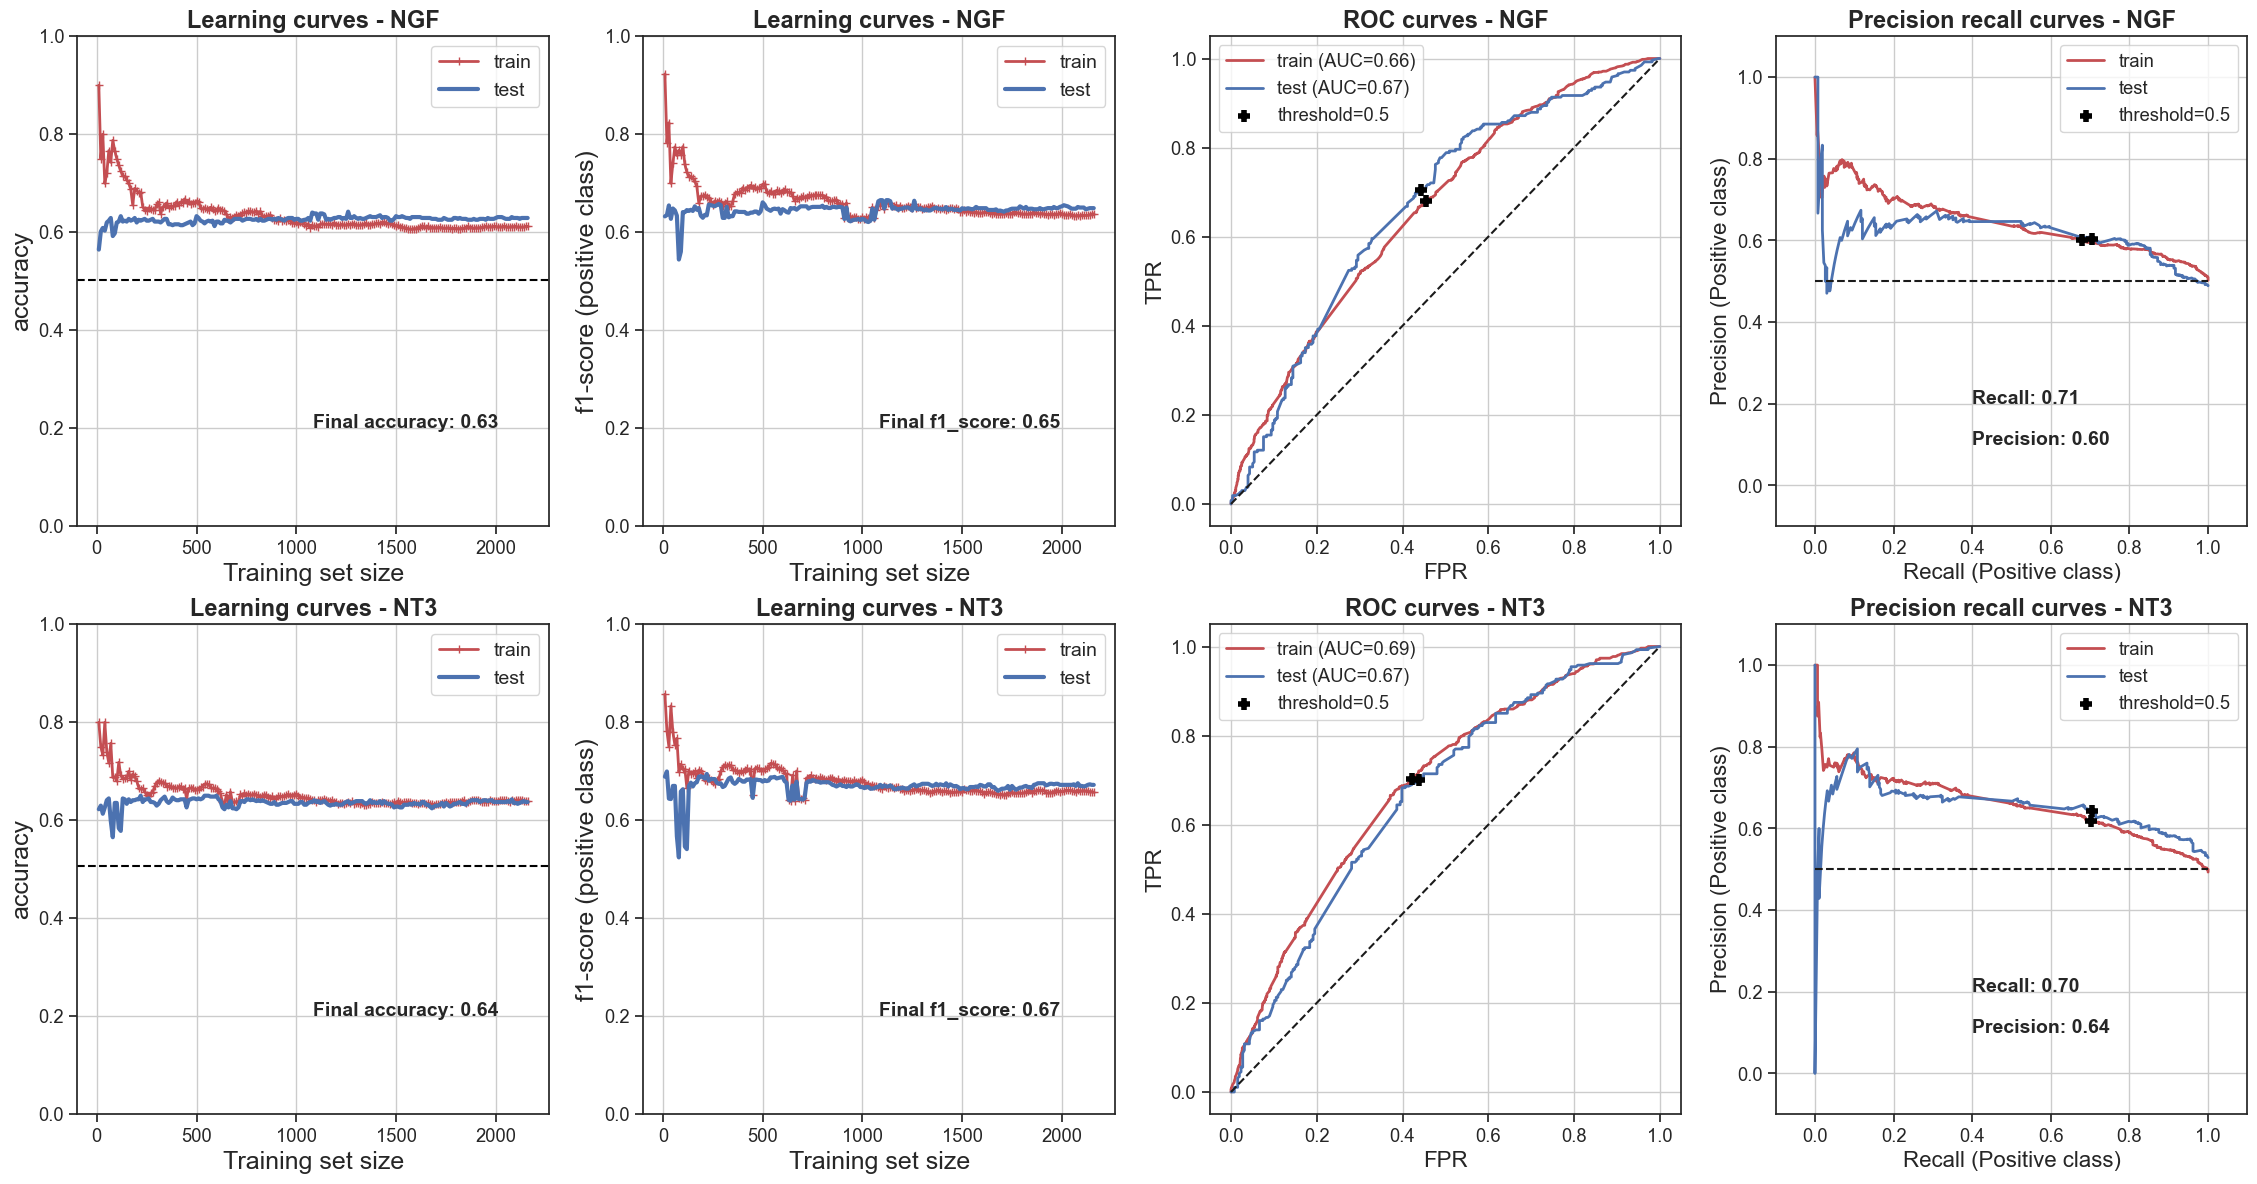

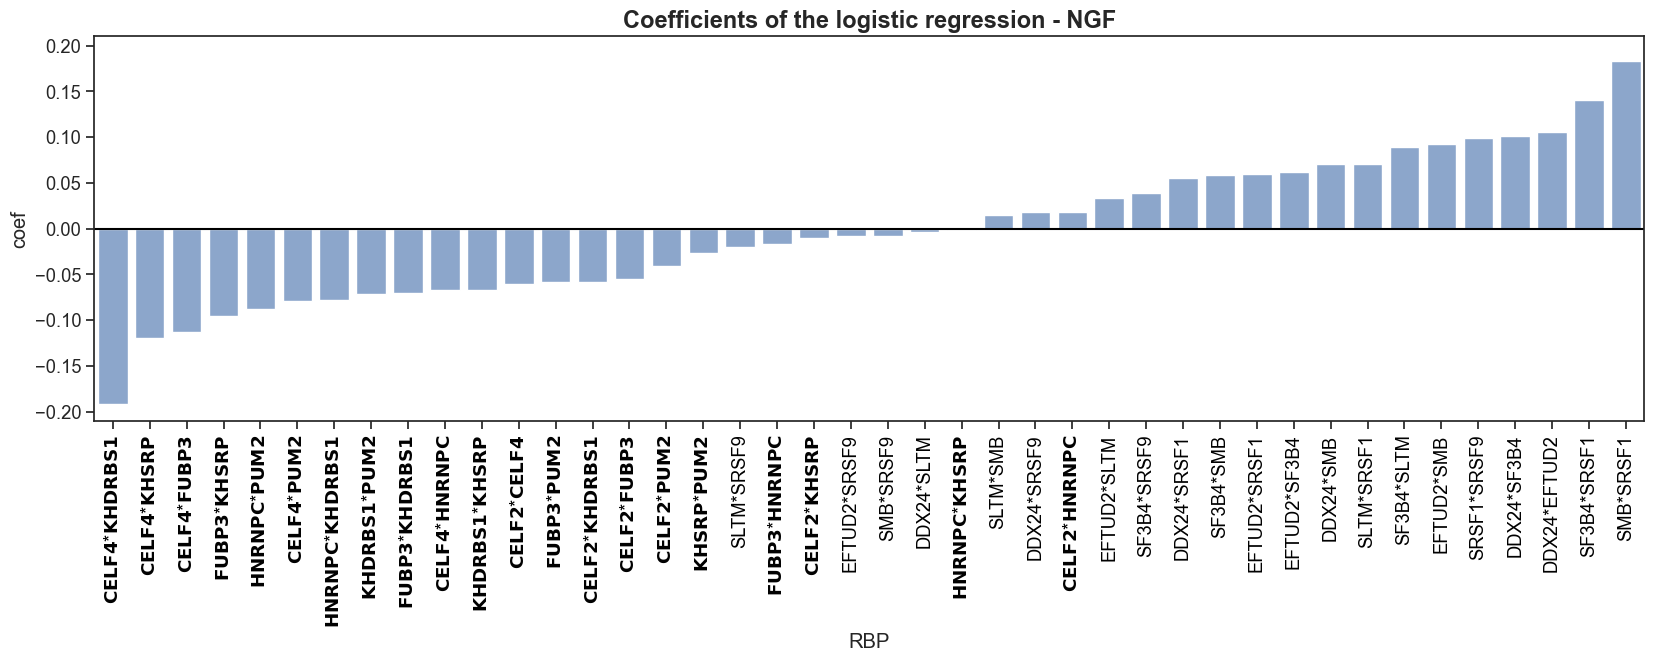

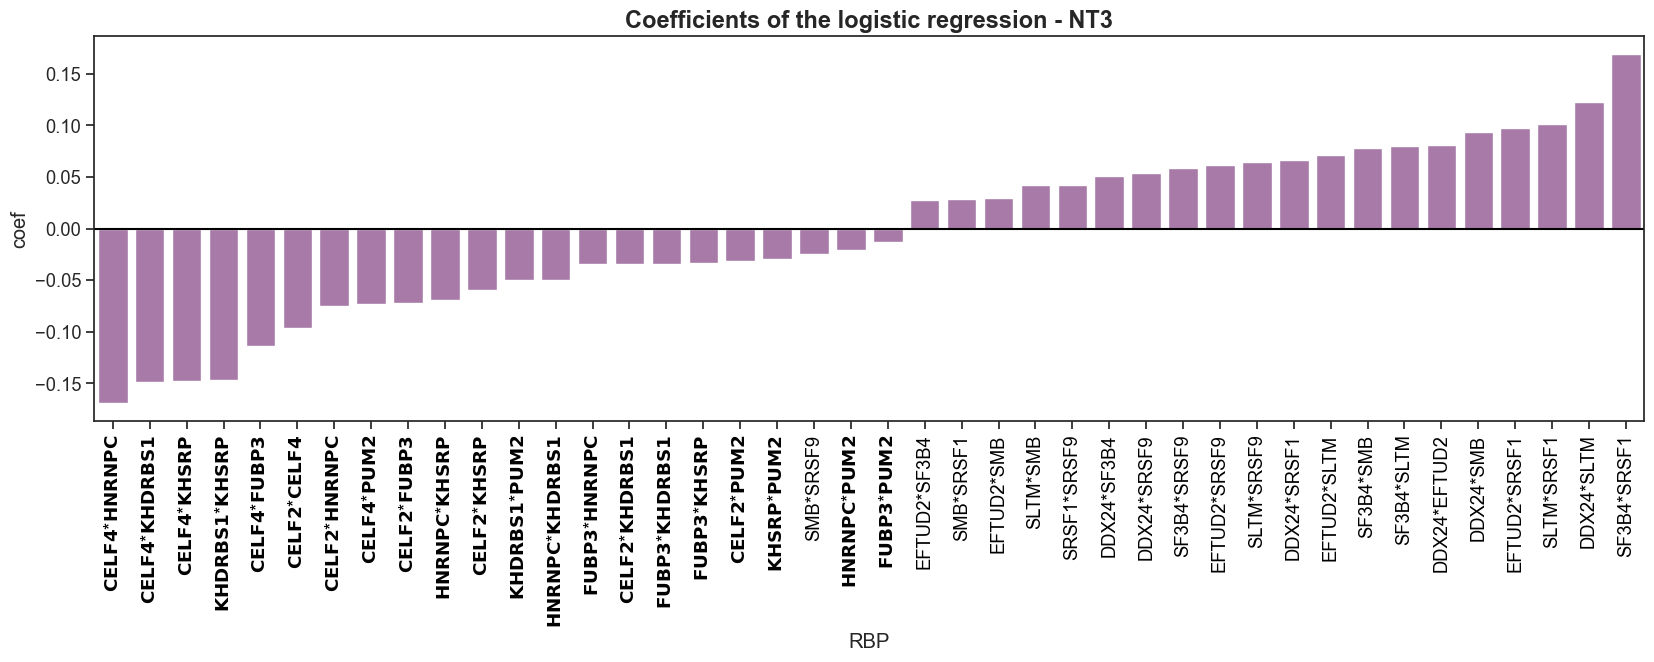

In [21]:
train_logistic_all_conditions(datasets_per_condition=datasets_per_condition, 
                              dataset_key='dataset_with_interactions', 
                              suffix='_interactions', include_plots=True,
                              conditions_names=['NGF', 'NT3'],
                              palette=palette,
                              step_learning=10, 
                              threshold=0.5,
                              feature_name_col='RBP',
                              negative_regulators=negative_regulators,                               
                              parameters_lr=parameters_lr)

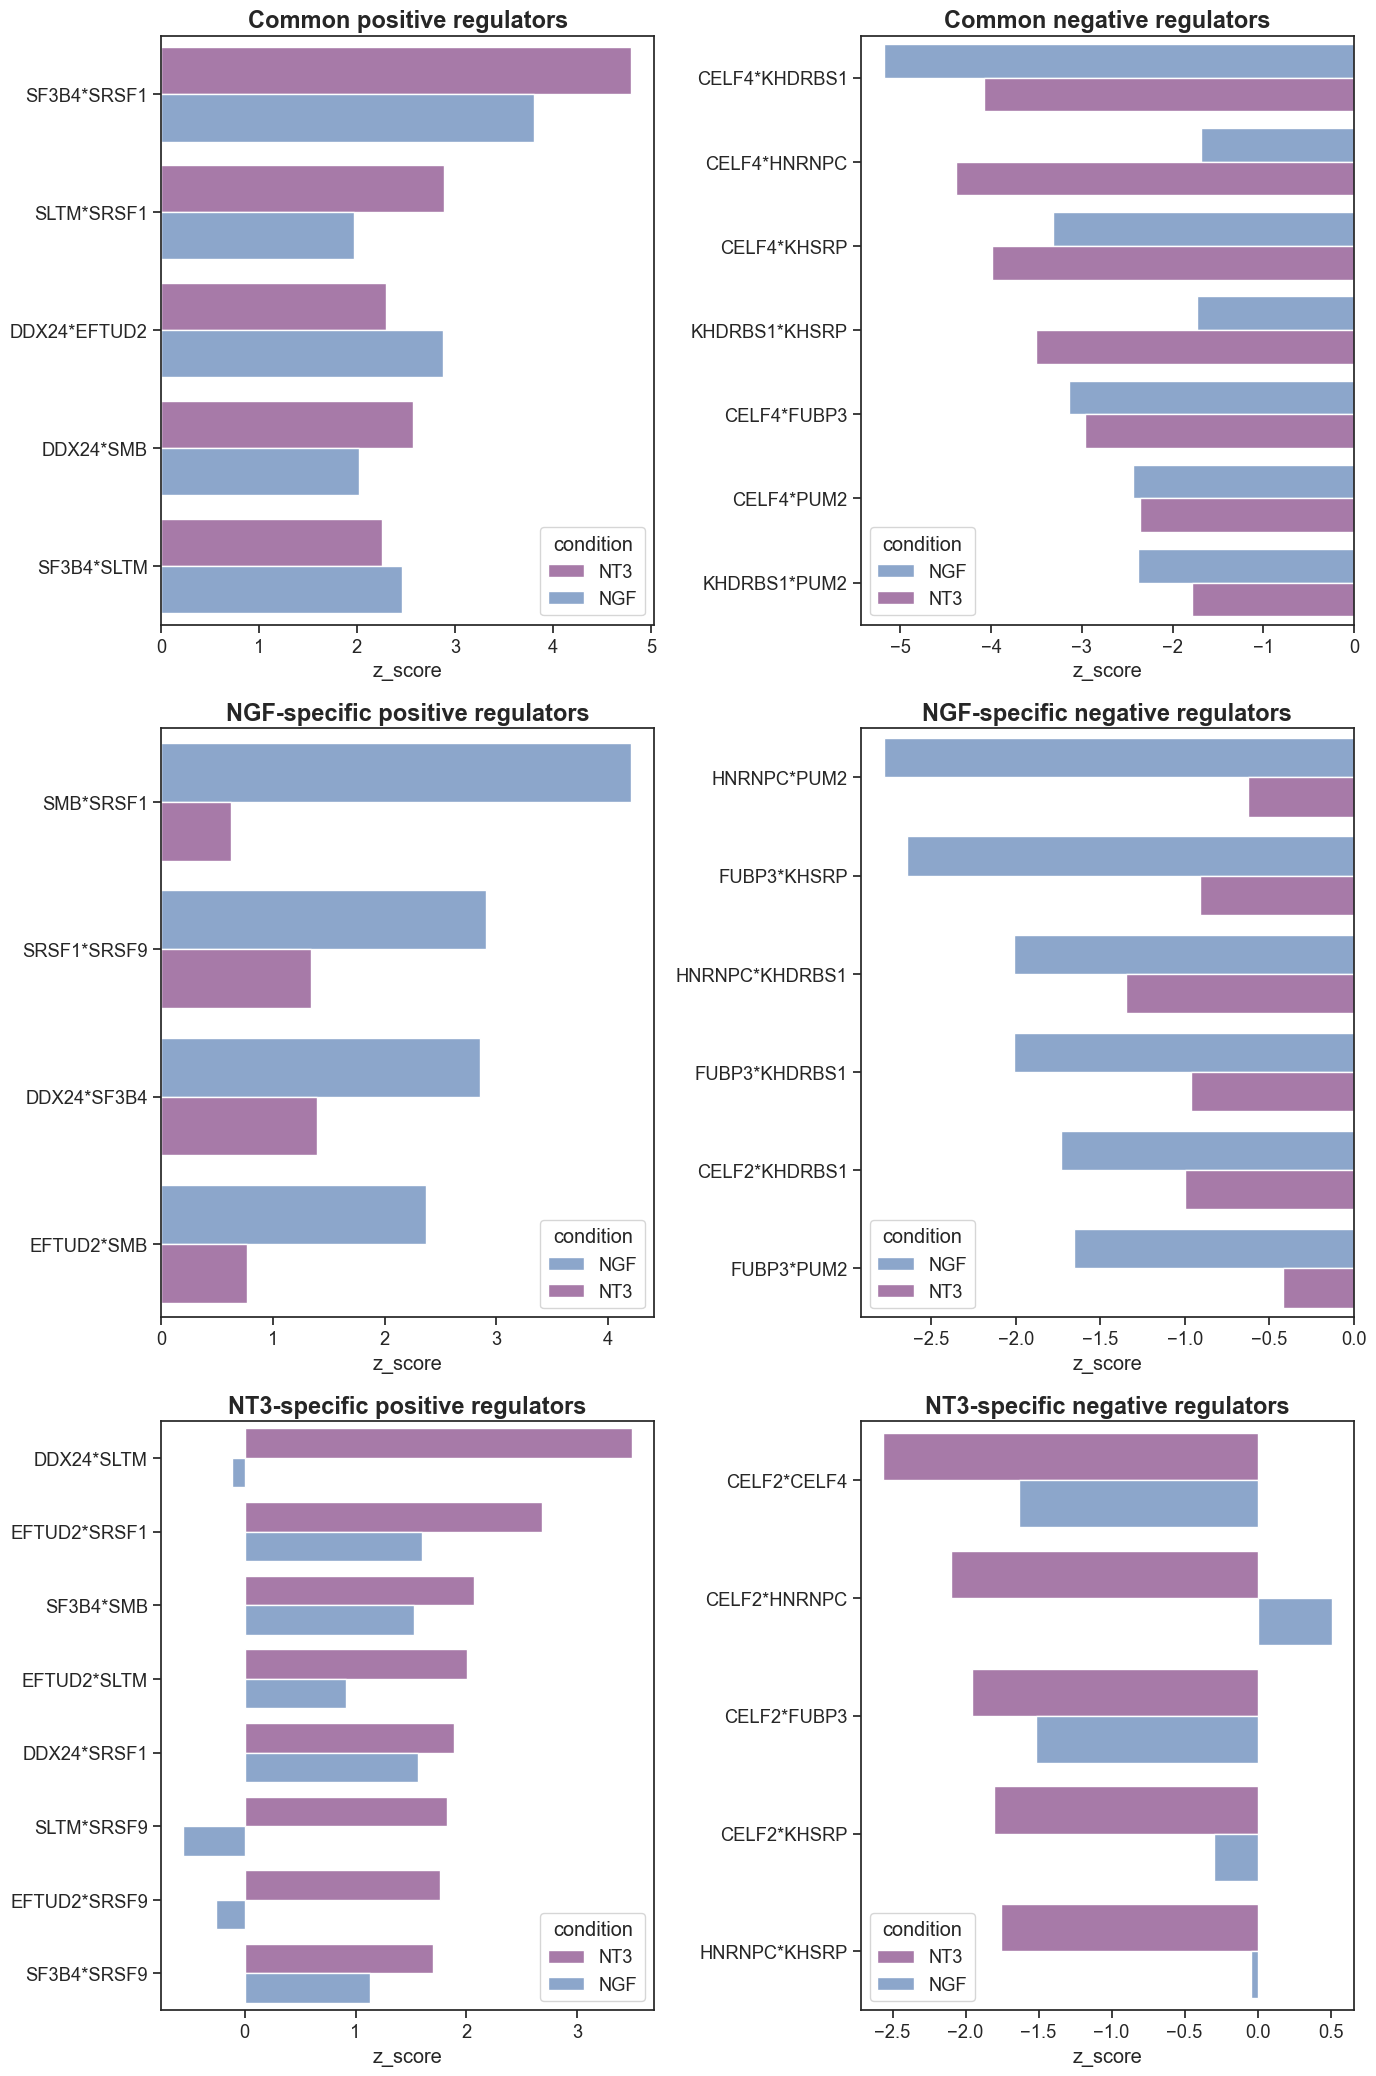

In [22]:
plot_common_and_specific_regulators_zscores(datasets_per_condition,
                                            feature_name='RBP',
                                         dataset_key='dataset_with_interactions',
                                         model_key='logit_model_interactions',
                                         conditions_names=conditions_names, 
                                         model1_name='NGF', 
                                         model2_name='NT3',
                                         n_permutations=2000,
                                         sig_threshold=0.05,
                                         palette_conditions=palette_conditions)

## 8. Model comparison (M1, M2, M3 & M4)

Text(0.5, 0.98, 'Classification scores of the logistic regression models the different feature sets')

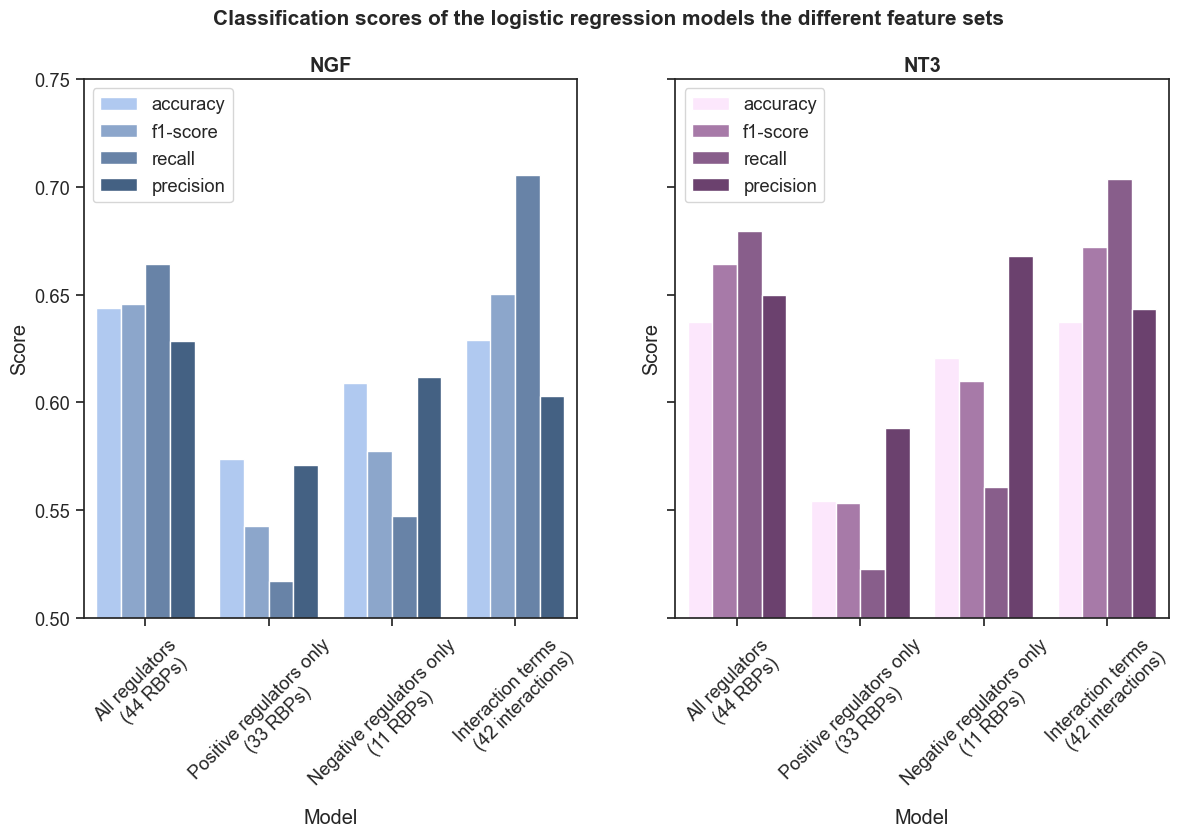

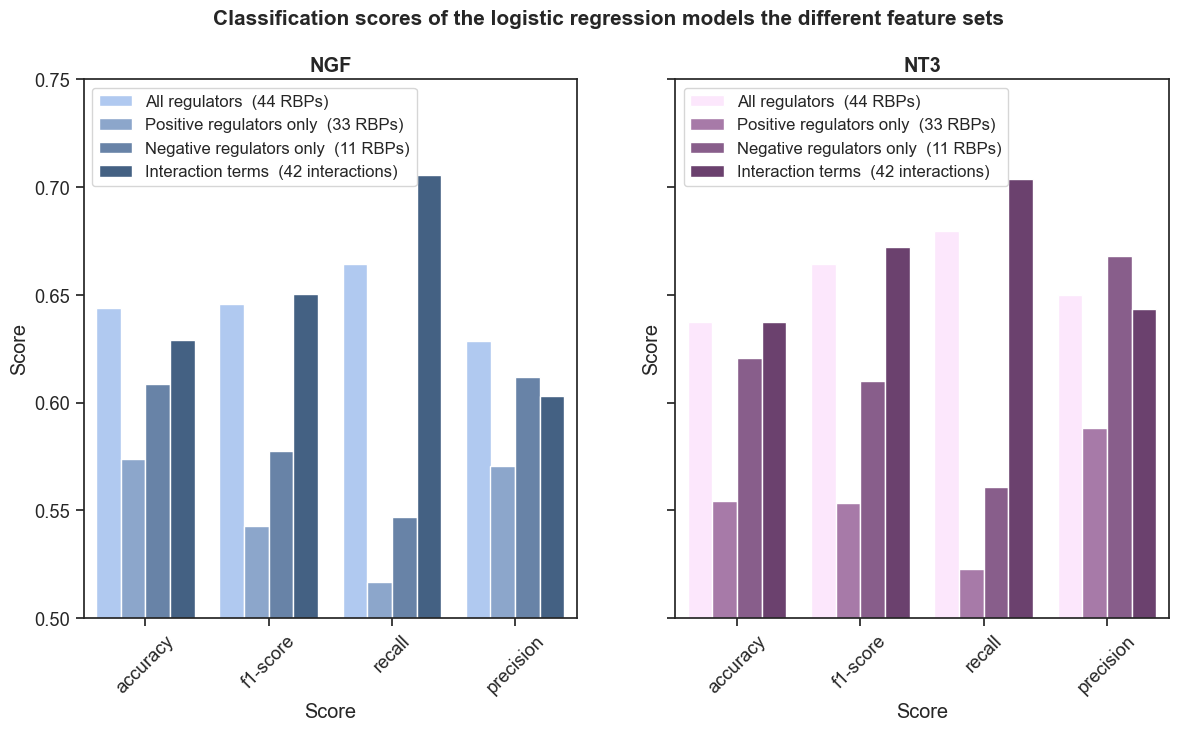

In [23]:
## Plot summarizing the metrics
dfs_summary = {}
for condition in datasets_per_condition.keys():
    
    dfs_summary[condition] = {}
    
    for dataset, model, name in zip(['dataset', 'dataset_positive', 'dataset_negative', 'dataset_with_interactions'],
                                    ['logit_model', 'logit_model_positive', 'logit_model_negative', 'logit_model_interactions'], 
                                    ['All regulators \n (44 RBPs)', 'Positive regulators only \n (33 RBPs)', 
                                     'Negative regulators only \n (11 RBPs)', "Interaction terms \n (42 interactions)"]):
    
        X_train, X_test, y_train, y_test = datasets_per_condition[condition][dataset].values()

        # Logistic regression 
        y_pred = datasets_per_condition[condition][model].predict(X_test)
        
        report = sklearn.metrics.classification_report(y_test, y_pred, output_dict=True)
        accuracy = report['accuracy']
        f1_score = report['1']['f1-score']
        recall = report['1']['recall']
        precision = report['1']['precision']
        dfs_summary[condition][name] = {'accuracy': accuracy, 
                                        'f1-score': f1_score, 
                                        'recall': recall, 
                                        'precision': precision}

fig, ax = plt.subplots(1, len(dfs_summary.keys()), figsize=(7*len(dfs_summary.keys()), 7), sharey=True)

for i, condition in enumerate(dfs_summary.keys()):
    df = pd.DataFrame(dfs_summary[condition])
    scores = list(df.index)
    df_plot = pd.melt(df, var_name='Model')
    df_plot['Score'] = scores*df.shape[1]
    
    sns.barplot(df_plot, x='Model', y='value', hue='Score', ax=ax[i], palette=continuous_palette[i])
    ax[i].legend(loc='upper left')
    ax[i].set_title(conditions_names[i], weight='bold')
    ax[i].set_xticks(ticks=np.arange(len(dfs_summary[condition].keys())), 
                     labels=dfs_summary[condition].keys(),
                     rotation=45)
    ax[i].set_ylabel("Score")
    ax[i].set_ylim(0.5, 0.75)
plt.suptitle("Classification scores of the logistic regression models the different feature sets", weight='bold', fontsize=15)


fig, ax = plt.subplots(1, len(dfs_summary.keys()), figsize=(7*len(dfs_summary.keys()), 7), sharey=True)

for i, condition in enumerate(dfs_summary.keys()):
    df = pd.DataFrame(dfs_summary[condition])
    scores = list(df.index)
    df_plot = pd.melt(df, var_name='Model')
    df_plot['Score'] = scores*df.shape[1]
    df_plot['Model'] = df_plot["Model"].apply(lambda x: "".join(x.split("\n")))
    
    sns.barplot(df_plot, x='Score', y='value', hue='Model', ax=ax[i], palette=continuous_palette[i])
    ax[i].legend(loc='upper left', fontsize=12)
    ax[i].set_title(conditions_names[i], weight='bold')
    ax[i].set_xticks(ticks=np.arange(len(scores)), 
                     labels=scores,
                     rotation=45)
    ax[i].set_ylabel("Score")
    ax[i].set_ylim(0.5, 0.75)
plt.suptitle("Classification scores of the logistic regression models the different feature sets", weight='bold', fontsize=15)
